# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time

pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 90)



# magic word for producing visualizations in notebook
%matplotlib inline


'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [9]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("./AZDIAS_Feature_Summary.csv", sep=";")
feat_info.set_index('attribute', inplace=True)

In [10]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
for df in [azdias, feat_info]:
    display(df.head())
    print(df.shape)
    print(df.dtypes)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


(891221, 85)
AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


(85, 3)
information_level     object
type                  object
missing_or_unknown    object
dtype: object


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
%%time
# Identify missing or unknown data values and convert them to NaNs.
for i, column in enumerate(azdias.columns):
    nan_codes = feat_info.loc[column]['missing_or_unknown']
    try:
        nan_codes = nan_codes.replace('XX', "'XX'")
        nan_codes_list = ast.literal_eval(nan_codes)
    except (ValueError, SyntaxError) as e:
        print(f"Error: {e} for {nan_codes} will replace with \'X\'")
        nan_codes = nan_codes.replace('X', "'X'")
        nan_codes_list = ast.literal_eval(nan_codes)

    azdias[column].replace(nan_codes_list, np.nan, inplace=True)
    

Error: malformed node or string: <ast.Name object at 0x7fa9e64a3310> for [-1,X] will replace with 'X'
CPU times: user 921 ms, sys: 135 ms, total: 1.06 s
Wall time: 1.06 s


In [16]:
# Sanity check to see if conversion worked.
print(f"azidas df head:")
display(azdias.head())
print(f"azidas df random:")
display(azdias.sample(n=5))

azidas df head:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


azidas df random:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
361515,2.0,4.0,2,2.0,4,1,5,1,2,3,5,1952.0,1.0,1,1.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,6.0,5.0,2,3,2,3,2,5,7,1,3,6,5,6,2,1,1.0,0.0,NaN,2.0,3,12.0,1.0,0.0,3.0,NaN,6.0,6.0,2.0,0.0,3.0,4.0,1992.0,W,3.0,4,4C,24,1.0,2.0,2.0,0.0,NaN,3.0,3.0,5.0,3.0,3.0,2.0,2.0,1.0,4.0,844.0,2.0,3.0,1.0,1.0,1.0,4.0,5.0,4.0,8.0,4.0
625730,NaN,3.0,2,4.0,2,2,3,4,2,4,6,1967.0,3.0,0,2.0,7.0,2.0,1.0,1.0,4.0,2.0,1.0,12.0,5.0,5,3,3,2,3,6,6,3,4,4,7,5,1,2,3.0,0.0,NaN,1.0,6,15.0,1.0,0.0,6.0,NaN,3.0,9.0,10.0,0.0,8.0,3.0,1994.0,O,3.0,8,8D,55,0.0,0.0,3.0,0.0,5.0,2.0,3.0,2.0,6.0,4.0,3.0,2.0,4.0,5.0,581.0,1.0,3.0,3.0,1.0,3.0,3.0,3.0,4.0,4.0,3.0
339876,2.0,4.0,2,6.0,4,1,5,2,3,3,2,1940.0,4.0,0,2.0,8.0,2.0,1.0,1.0,3.0,2.0,1.0,3.0,5.0,4,1,4,4,4,5,7,1,4,7,6,6,4,1,2.0,0.0,NaN,1.0,3,10.0,1.0,0.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
812658,NaN,2.0,1,5.0,4,4,2,4,5,1,3,1978.0,10.0,0,2.0,35.0,11.0,10.0,5.0,10.0,5.0,1.0,14.0,3.0,7,7,6,7,6,3,2,7,5,5,4,4,7,5,2.0,0.0,NaN,2.0,1,17.0,3.0,0.0,3.0,2.0,2.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,7,7B,41,2.0,1.0,0.0,0.0,NaN,5.0,NaN,NaN,NaN,4.0,3.0,5.0,5.0,6.0,1400.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,4.0,1.0
347760,NaN,2.0,2,5.0,1,4,2,4,5,4,1,1986.0,10.0,0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,1.0,2,5,5,7,4,4,5,4,4,4,7,7,4,7,1.0,0.0,NaN,1.0,5,19.0,1.0,0.0,4.0,NaN,6.0,6.0,4.0,0.0,1.0,2.0,1992.0,W,2.0,5,5A,31,1.0,3.0,0.0,0.0,NaN,3.0,3.0,4.0,5.0,4.0,NaN,3.0,4.0,NaN,525.0,2.0,3.0,2.0,1.0,1.0,4.0,4.0,2.0,6.0,2.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isna().mean().sort_values(ascending=False)


TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
KKK                      0.177357
REGIOTYP                 0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_ANTG1               0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
SHOPPER_TYP              0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

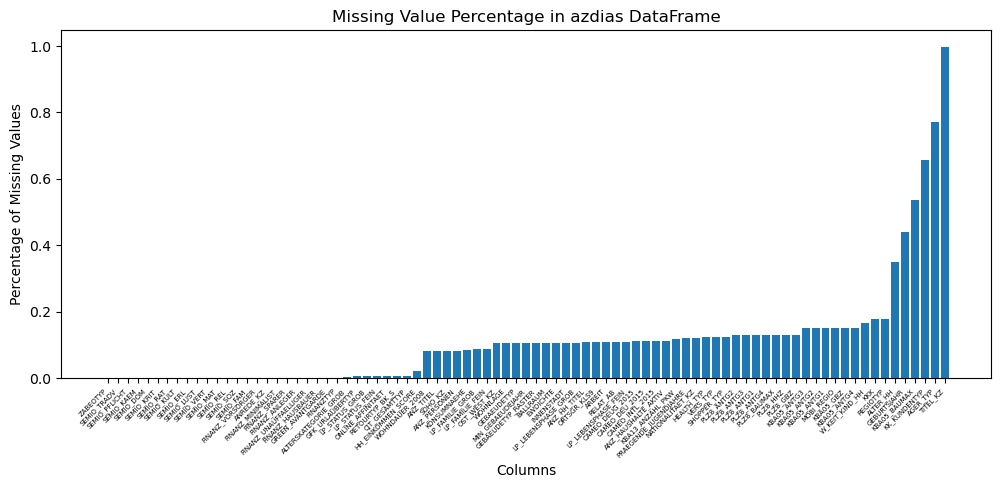

In [18]:
nan_percentages = azdias.isna().mean().sort_values()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(nan_percentages.index, nan_percentages.values)
plt.xticks(rotation=45)

# Customizing the x-axis ticks and labels
plt.xticks(range(len(nan_percentages.index)), nan_percentages.index, fontsize=5, ha='right')

plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Value Percentage in azdias DataFrame')

# Add more space to the bottom of the plot
plt.subplots_adjust(bottom=0.3)

plt.show()

# Investigate patterns in the amount of missing data in each column.
The following
- 2.1 ALTER_HH 0.348137: Birthdate of head of household
- 1.7 GEBURTSJAHR 0.440203: Year of birth
- 5.5 KBA05_BAUMAX 0.534687: Most common building type within the microcell
- 2.5 KK_KUNDENTYP 0.655967: Consumer pattern over past 12 months
- 1.1 AGER_TYP 0.769554: Best-ager typology
- 1.23 TITEL_KZ 0.997576: Academic title flag


- 2: Household-level features (2)
- 1: Person-level features (3)
- 5: RR3 micro-cell features

The RR3 micro-cell features quantify the utility of the buildings for a particular cell. Specifically, the feature KBA05_BAUMAX 0.534687: Most common building type within the microcell has Over 50% are NAN. We can speculate that those particular data were difficult to ascertain or collect.

The three presonal-level features
- 1.1 AGER_TYP 0.769554: Best-ager typology
- 1.23 TITEL_KZ 0.997576: Academic title flag
- 1.7 GEBURTSJAHR 0.440203: Year of birth


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

OUTLIER_COLS = ['ALTER_HH', 'GEBURTSJAHR','KBA05_BAUMAX',
            'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']

azdias_no_out = azdias.copy() 
azdias_no_out.drop(columns=OUTLIER_COLS, inplace=True)

print(f"azidas shape: {azdias.shape}")
print(f"azidas_no_out shape: {azdias_no_out.shape}")

azidas shape: (891221, 85)
azidas_no_out shape: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

For each feature, there were a set of values which were indicative of missing data. <br>
Each feature column was standardized with NaNs as replacement values for the missing data. <br>
After this operation, the number of NaN values were averaged with the mean() function and sorted in ascending order. <br>
A decision was made to drop features with NaN mean() values greater than 0.178. <br>
Consequently, 6 features were removed from the intitial analysis. 
- REGIOTYP                 0.177357
- **ALTER_HH**                 0.348137
- **GEBURTSJAHR**              0.440203
- **KBA05_BAUMAX**             0.534687
- **KK_KUNDENTYP**             0.655967
- **AGER_TYP**                 0.769554
- **TITEL_KZ**                0.997576

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?

nan_row_count = azdias_no_out.isna().sum(axis=1)
azdias_no_out['NANS_P_ROW'] = nan_row_count
row_groups = azdias_no_out.groupby('NANS_P_ROW').size()
print(row_groups)

NANS_P_ROW
0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64


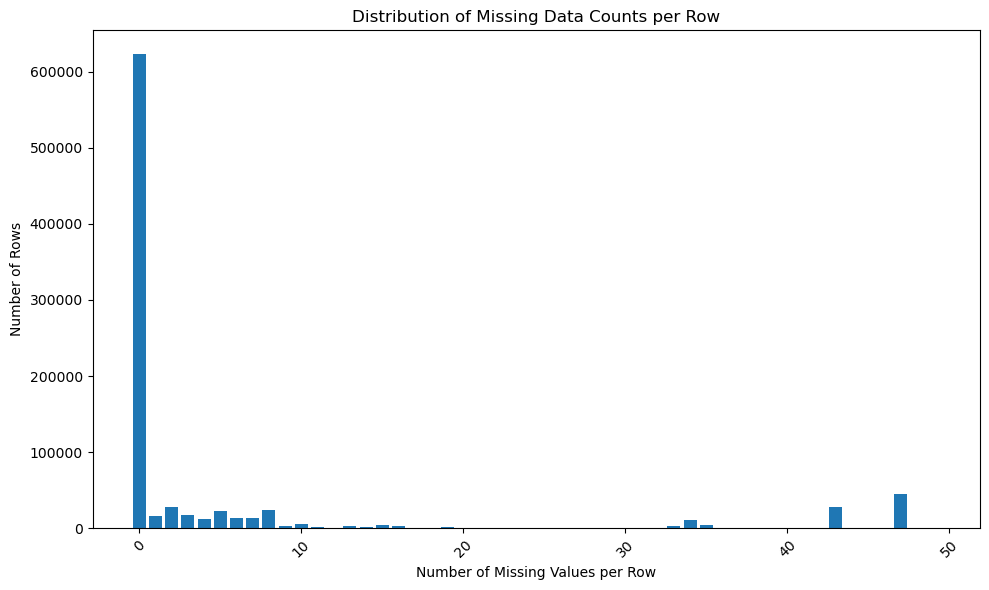

In [21]:
# Plot the distribution of missing data counts
plt.figure(figsize=(10, 6))
plt.bar(row_groups.index, row_groups.values)
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Data Counts per Row')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

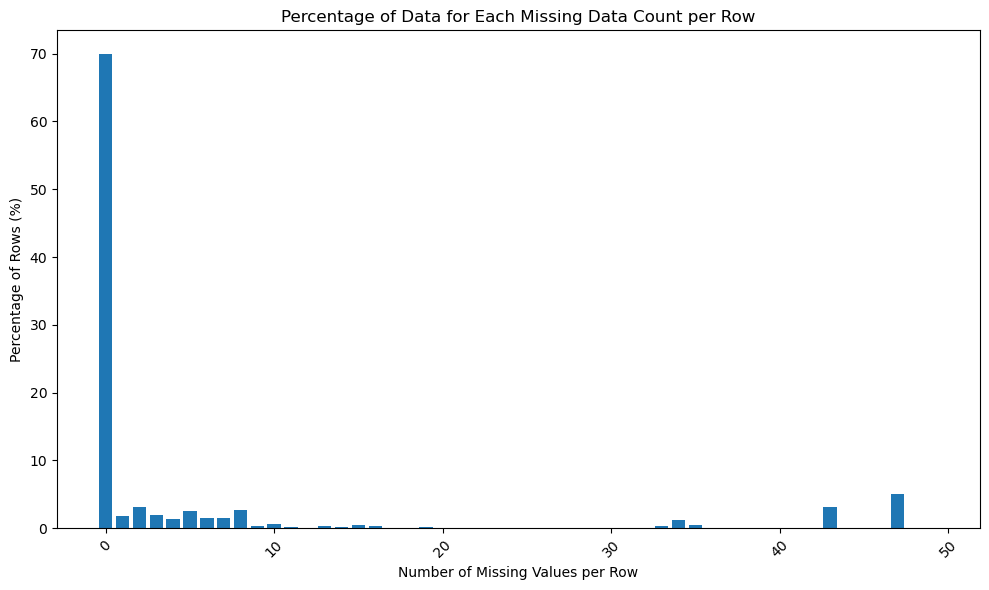

In [22]:
# Calculate the percentage of data for each NAN count
nan_row_count = azdias_no_out.isna().sum(axis=1)
nan_counts = nan_row_count.value_counts()
total_rows = len(azdias_no_out)
nan_percentages = (nan_counts / total_rows) * 100

# Plot the percentage of data for each NAN count
plt.figure(figsize=(10, 6))
plt.bar(nan_percentages.index, nan_percentages.values)
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Percentage of Rows (%)')
plt.title('Percentage of Data for Each Missing Data Count per Row')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [101]:
# Sanity Check for rows with a specific NANS count (0)
rows_with_0_nans = azdias_no_out[azdias_no_out['NANS_P_ROW'] == 0]
rows_with_0_nans.sample(n=5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NANS_P_ROW
842532,3.0,1,5.0,3,3,4,1,2,3,5,8.0,0,3.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,6,6,4,4,5,6,4,6,2,5,2,3,5,4,2.0,0.0,2.0,3,1.0,0.0,6.0,5.0,9.0,11.0,0.0,1.0,1.0,1992.0,W,3.0,9,9D,51,0.0,0.0,2.0,1.0,2.0,6.0,6.0,2.0,3.0,2.0,1.0,1.0,3.0,381.0,1.0,3.0,3.0,2.0,4.0,4.0,2.0,4.0,7.0,5.0,0
596421,3.0,2,4.0,2,1,5,1,2,5,5,12.0,0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,1,1,3,3,2,6,6,3,4,7,7,7,3,3,2.0,0.0,1.0,4,1.0,0.0,5.0,4.0,9.0,8.0,0.0,1.0,4.0,1993.0,W,4.0,2,2D,14,3.0,1.0,0.0,1.0,3.0,6.0,4.0,5.0,4.0,2.0,3.0,2.0,6.0,797.0,3.0,2.0,1.0,0.0,1.0,4.0,5.0,4.0,6.0,3.0,0
38445,3.0,1,3.0,5,2,3,3,2,1,6,5.0,0,3.0,19.0,5.0,2.0,2.0,9.0,4.0,1.0,12.0,3.0,6,4,4,1,7,4,4,5,2,5,5,3,4,2,0.0,0.0,2.0,4,2.0,0.0,3.0,3.0,9.0,1.0,0.0,1.0,5.0,1992.0,O,7.0,4,4C,24,3.0,0.0,0.0,0.0,5.0,6.0,2.0,7.0,4.0,3.0,5.0,3.0,5.0,577.0,3.0,1.0,1.0,0.0,1.0,3.0,4.0,2.0,1.0,1.0,0
777012,3.0,1,1.0,4,3,4,4,2,1,6,12.0,0,3.0,11.0,3.0,1.0,1.0,9.0,4.0,2.0,8.0,4.0,3,4,4,1,5,6,4,6,2,5,5,3,5,2,2.0,0.0,2.0,3,1.0,0.0,6.0,5.0,9.0,2.0,0.0,1.0,3.0,1992.0,W,7.0,6,6B,43,2.0,1.0,0.0,0.0,5.0,4.0,2.0,6.0,4.0,3.0,4.0,0.0,6.0,1027.0,3.0,2.0,0.0,0.0,1.0,4.0,5.0,2.0,2.0,3.0,0
120212,4.0,1,1.0,4,1,5,1,2,4,5,3.0,1,1.0,8.0,2.0,1.0,1.0,3.0,2.0,1.0,6.0,3.0,6,4,2,4,7,7,3,6,1,3,3,2,1,1,3.0,0.0,1.0,3,1.0,0.0,4.0,6.0,9.0,23.0,0.0,8.0,4.0,1992.0,W,2.0,6,6E,45,0.0,0.0,0.0,2.0,1.0,6.0,6.0,8.0,5.0,2.0,1.0,4.0,3.0,513.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0,0


In [102]:
# Sanity Check for rows with a specific NANS count (9)
rows_with_9_nans = azdias_no_out[azdias_no_out['NANS_P_ROW'] == 9]
rows_with_9_nans.sample(n=5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NANS_P_ROW
444837,4.0,1,1.0,5,1,5,1,3,1,2,12.0,0,1.0,9.0,3.0,1.0,1.0,6.0,3.0,1.0,NaN,4.0,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,1.0,3,1.0,0.0,3.0,6.0,8.0,2.0,0.0,3.0,5.0,2008.0,W,8.0,3,3C,24,NaN,NaN,NaN,NaN,NaN,6.0,2.0,6.0,1.0,NaN,NaN,2.0,NaN,1020.0,4.0,2.0,0.0,0.0,1.0,4.0,5.0,2.0,1.0,1.0,9
570533,3.0,1,1.0,3,1,5,2,1,5,6,5.0,0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN,3.0,5.0,4,4,7,5,4,7,7,4,4,4,4,4,7,4,NaN,0.0,NaN,6,0.0,0.0,6.0,NaN,9.0,10.0,0.0,8.0,5.0,1992.0,W,3.0,7,7C,54,0.0,0.0,2.0,1.0,1.0,4.0,3.0,5.0,4.0,4.0,1.0,0.0,7.0,489.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0,9
484773,4.0,1,2.0,4,1,5,2,1,5,6,12.0,0,2.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,NaN,4.0,6,6,3,6,6,7,7,6,3,3,3,2,3,1,2.0,0.0,1.0,3,1.0,0.0,6.0,6.0,9.0,10.0,0.0,1.0,4.0,1992.0,W,7.0,9,9D,51,1.0,3.0,1.0,0.0,3.0,6.0,3.0,7.0,3.0,3.0,2.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,4.0,9
732232,3.0,2,3.0,2,4,1,2,4,3,4,8.0,1,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,15.0,4.0,5,5,7,5,1,5,3,3,4,4,6,6,7,3,NaN,0.0,NaN,5,0.0,0.0,5.0,NaN,8.0,7.0,0.0,8.0,2.0,1992.0,W,5.0,9,9C,51,1.0,3.0,0.0,0.0,3.0,2.0,6.0,1.0,4.0,2.0,3.0,3.0,3.0,335.0,2.0,4.0,2.0,1.0,2.0,4.0,3.0,4.0,7.0,5.0,9
584750,2.0,2,5.0,3,2,4,3,2,3,6,12.0,0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,10.0,2.0,1,4,5,4,1,7,7,3,6,4,5,6,7,3,NaN,0.0,NaN,3,0.0,0.0,5.0,NaN,9.0,10.0,0.0,1.0,2.0,1993.0,W,4.0,6,6F,45,0.0,3.0,2.0,0.0,2.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,2.0,309.0,1.0,3.0,3.0,2.0,4.0,3.0,2.0,3.0,5.0,4.0,9


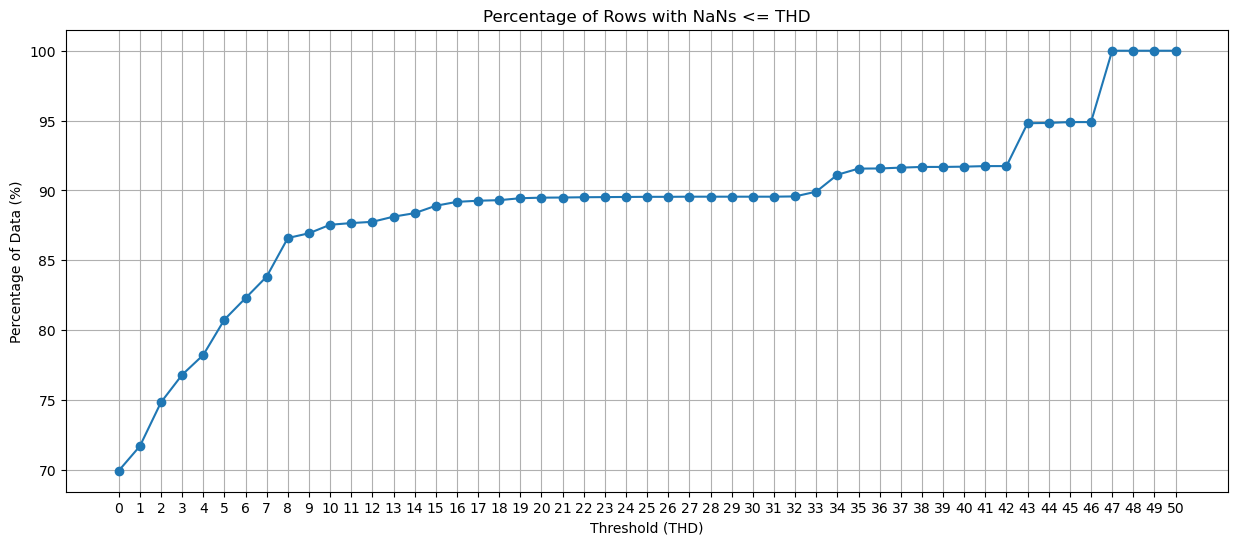

In [122]:
def process_threshold(threshold, azdias_data):
    azdias_subset = azdias_data[azdias_data['NANS_P_ROW'] <= threshold]
    TDR_lte_THD = azdias_subset.shape[0]
    percent_lte_THD = np.round(TDR_lte_THD * 100 / TDR, 2)
    return percent_lte_THD

# Calculate the total data rows
TDR = azdias_no_out.shape[0]

# List to store the percentage values
percentages = []

# Iterate through a range of threshold values
for THD in range(51):  # Adjust the range as needed
    percent = process_threshold(THD, azdias_no_out)
    percentages.append(percent)

# Plot THD vs Percentage
plt.figure(figsize=(15, 6))
plt.plot(range(51), percentages, marker='o')
plt.xlabel('Threshold (THD)')
plt.ylabel('Percentage of Data (%)')
plt.title('Percentage of Rows with NaNs <= THD')
plt.grid(True)
plt.xticks(range(51))
plt.show()

In [15]:
%%time
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Maximizing the percentage of data coverage with a minimal amount of missing rows,
# a threshold of 20 was chosen to capture ~90% of the data
THD = 20 # (THD) THRESHOLD
azdias_no_out_less_than_THD = azdias_no_out[azdias_no_out['NANS_P_ROW'] <= THD]
azdias_no_out_great_than_THD = azdias_no_out[azdias_no_out['NANS_P_ROW'] > THD]

# Drop the 'NaN_Count' column if not needed
azdias_no_out_less_than_THD.drop('NANS_P_ROW', axis=1, inplace=True)
azdias_no_out_great_than_THD.drop('NANS_P_ROW', axis=1, inplace=True)

# Print the resulting DataFrames
TDR = azdias_no_out.shape[0]

print("Total Dataframe:")
print(azdias_no_out.shape)

TDR_lte_THD = azdias_no_out_less_than_THD.shape[0]
print(f"Dataframe with less than or equal to {THD} NaN:")
print(f"Shape: {azdias_no_out_less_than_THD.shape}, Percent: {np.round(TDR_lte_THD*100/TDR, 2)}")

TDR_gt_THD = azdias_no_out_great_than_THD.shape[0]
print(f"\nDataframe with more than {THD} NaN:")
print(azdias_no_out_great_than_THD.shape)
print(f"Shape: {azdias_no_out_great_than_THD.shape}, Percent: {np.round(TDR_gt_THD*100/TDR, 2)}")


Total Dataframe:
(891221, 80)
Dataframe with less than or equal to 20 NaN:
Shape: (797426, 79), Percent: 89.48

Dataframe with more than 20 NaN:
(93795, 79)
Shape: (93795, 79), Percent: 10.52
CPU times: user 333 ms, sys: 182 ms, total: 515 ms
Wall time: 521 ms


<timed exec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# We will randomly choose rows from both df subsets:
# - azdias_no_out_less_than_THD
# - azdias_no_out_great_than_THD
# in order to select the columns for distribution plots.

display(azdias_no_out_less_than_THD.sample(n=10))
display(azdias_no_out_great_than_THD.sample(n=10))

# From the analysis, we chose the following columns:
SUBSET_COLS = ['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',	
 'CJT_GESAMTTYP',	
'FINANZ_MINIMALIST',	
'FINANZ_SPARER',	
'FINANZ_VORSORGER',	
'FINANZ_ANLEGER',	
'FINANZ_UNAUFFAELLIGER',	
'FINANZ_HAUSBAUER',	
'FINANZTYP',	
'GFK_URLAUBERTYP',	
'GREEN_AVANTGARDE',
'LP_STATUS_FEIN',	
'LP_STATUS_GROB',
'ONLINE_AFFINITAET',
'HH_EINKOMMEN_SCORE',
'ZABEOTYP',
'RETOURTYP_BK_S',	
'SEMIO_SOZ',	
'SEMIO_FAM',	
'SEMIO_REL',	
'SEMIO_MAT',	
'SEMIO_VERT',	
'SEMIO_LUST',	
'SEMIO_ERL',	
'SEMIO_KULT',	
'SEMIO_RAT',	
'SEMIO_KRIT',	
'SEMIO_DOM',	
'SEMIO_KAEM',	
'SEMIO_PFLICHT',	
'SEMIO_TRADV']

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
196425,1.0,1,3.0,3,3,4,2,2,3,6,9.0,0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,3.0,7,7,7,3,6,2,2,7,4,2,2,2,7,5,1.0,0.0,2.0,6,1.0,0.0,6.0,6.0,3.0,5.0,0.0,8.0,3.0,1992.0,W,4.0,8,8C,54,0.0,3.0,3.0,0.0,2.0,2.0,6.0,4.0,4.0,4.0,2.0,2.0,7.0,303.0,2.0,4.0,2.0,1.0,2.0,3.0,2.0,5.0,7.0,5.0
306851,4.0,2,2.0,5,1,5,2,2,2,2,10.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,6.0,2.0,5,1,2,1,2,7,7,2,2,7,5,5,1,1,3.0,0.0,1.0,3,1.0,0.0,2.0,6.0,9.0,1.0,0.0,1.0,4.0,1992.0,W,3.0,2,2B,13,4.0,1.0,0.0,0.0,4.0,6.0,3.0,5.0,5.0,3.0,5.0,1.0,5.0,858.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,4.0,2.0
117869,4.0,2,2.0,5,1,5,2,1,2,2,6.0,0,2.0,12.0,3.0,1.0,1.0,9.0,4.0,1.0,3.0,3.0,1,1,1,3,2,5,7,1,2,6,6,5,2,3,1.0,0.0,2.0,3,1.0,0.0,5.0,6.0,9.0,2.0,0.0,1.0,4.0,1997.0,W,5.0,7,7A,41,2.0,1.0,0.0,0.0,5.0,6.0,2.0,8.0,4.0,3.0,5.0,1.0,4.0,868.0,3.0,2.0,0.0,0.0,1.0,4.0,5.0,3.0,4.0,5.0
174447,3.0,1,4.0,3,3,4,2,2,2,6,7.0,0,3.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,3,4,4,4,5,6,4,6,2,5,2,3,5,4,2.0,0.0,2.0,6,1.0,0.0,5.0,6.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,1.0,8,8B,41,1.0,2.0,1.0,0.0,3.0,3.0,5.0,5.0,2.0,2.0,2.0,2.0,3.0,239.0,2.0,3.0,2.0,0.0,1.0,3.0,3.0,3.0,5.0,2.0
301803,3.0,1,5.0,5,2,3,2,3,1,6,4.0,1,3.0,35.0,11.0,9.0,5.0,10.0,5.0,1.0,11.0,5.0,6,5,4,6,7,4,4,6,5,5,5,3,3,4,1.0,0.0,2.0,2,2.0,0.0,1.0,4.0,9.0,1.0,0.0,8.0,2.0,1993.0,W,2.0,3,3B,23,2.0,1.0,0.0,0.0,5.0,4.0,4.0,5.0,4.0,2.0,5.0,3.0,2.0,958.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,3.0,5.0,1.0
666580,3.0,1,3.0,5,1,5,1,3,2,2,9.0,0,3.0,23.0,6.0,4.0,3.0,9.0,4.0,1.0,8.0,4.0,3,6,4,6,7,4,4,5,5,5,2,3,4,4,1.0,0.0,1.0,2,1.0,0.0,2.0,1.0,9.0,1.0,0.0,1.0,5.0,1995.0,W,8.0,3,3A,23,NaN,NaN,NaN,NaN,NaN,6.0,2.0,5.0,5.0,NaN,NaN,4.0,NaN,322.0,4.0,2.0,1.0,0.0,1.0,2.0,3.0,3.0,1.0,2.0
332225,3.0,2,5.0,2,1,5,2,1,5,6,12.0,0,3.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,2.0,1,3,3,2,4,6,6,3,4,4,7,7,5,3,2.0,0.0,1.0,3,1.0,0.0,6.0,4.0,9.0,7.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,0.0,0.0,3.0,0.0,2.0,4.0,5.0,3.0,3.0,2.0,1.0,4.0,3.0,775.0,2.0,4.0,2.0,1.0,2.0,4.0,3.0,4.0,7.0,5.0
766338,1.0,1,4.0,1,5,3,5,5,5,1,11.0,0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,14.0,1.0,7,7,7,5,6,1,1,7,4,2,2,2,6,5,0.0,0.0,2.0,4,1.0,0.0,6.0,6.0,9.0,12.0,0.0,1.0,4.0,1992.0,W,4.0,8,8C,54,0.0,0.0,2.0,1.0,1.0,2.0,5.0,4.0,4.0,3.0,1.0,3.0,5.0,530.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,4.0,6.0,5.0
813716,2.0,2,4.0,1,5,2,5,3,3,1,11.0,0,2.0,29.0,9.0,10.0,5.0,2.0,1.0,1.0,14.0,2.0,5,5,5,3,1,3,5,5,7,7,6,7,7,7,3.0,0.0,2.0,4,4.0,0.0,6.0,2.0,9.0,9.0,0.0,1.0,2.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,3.0,4.0,5.0,4.0,3.0,1.0,5.0,6.0,489.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,4.0,5.0,5.0
787691,1.0,2,4.0,5,1,5,2,2,2,2,8.0,0,3.0,37.0,12.0,10.0,5.0,9.0,4.0,1.0,8.0,3.0,5,2,7,3,1,3,4,6,7,4,4,6,7,6,2.0,0.0,1.0,1,6.0,0.0,2.0,2.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,3,3C,24,4.0,0.0,0.0,0.0,4.0,6.0,4.0,6.0,3.0,3.0,5.0,4.0,6.0,814.0,4.0,2.0,0.0,0.0,1.0,4.0,5.0,2.0,3.0,1.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
19240,1.0,2,5.0,5,1,5,1,3,2,2,1.0,0,NaN,12.0,3.0,1.0,1.0,9.0,4.0,NaN,5.0,5.0,2,6,7,5,1,5,3,3,5,7,6,6,5,3,NaN,0.0,NaN,3,1.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107235,3.0,2,5.0,3,4,3,5,5,3,4,1.0,0,NaN,NaN,NaN,10.0,5.0,2.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3355,4.0,2,3.0,5,1,5,3,3,3,2,10.0,0,1.0,28.0,8.0,8.0,4.0,10.0,5.0,1.0,NaN,5.0,4,1,4,4,4,5,7,2,4,7,6,6,4,1,3.0,0.0,1.0,3,4.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540122,1.0,2,6.0,3,4,3,5,5,3,4,1.0,0,NaN,27.0,8.0,8.0,4.0,9.0,4.0,NaN,NaN,1.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728114,2.0,2,1.0,3,4,3,5,5,3,4,4.0,0,NaN,10.0,3.0,1.0,1.0,9.0,4.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623487,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373072,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251540,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658019,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550348,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


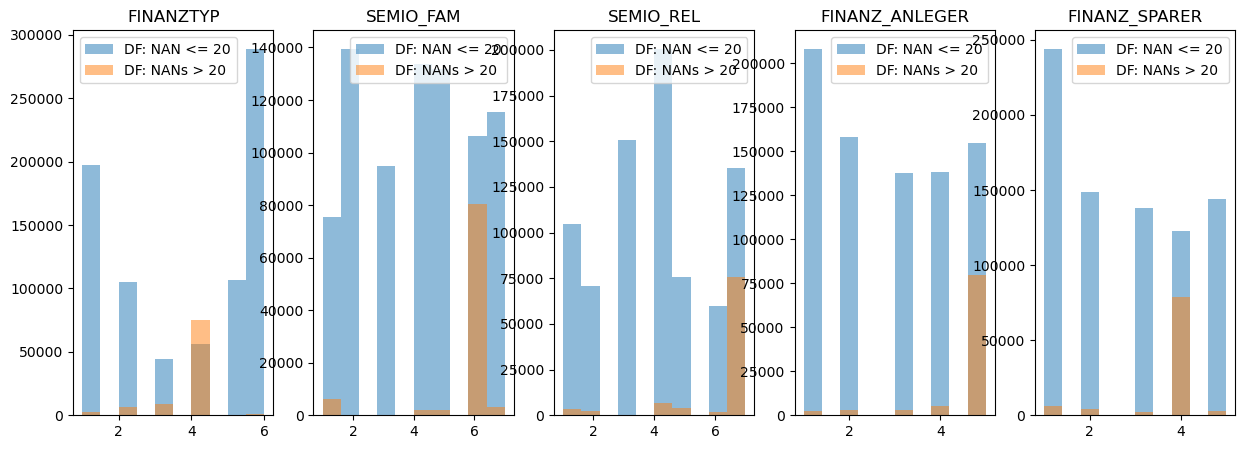

In [127]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Columns to plot
# Choose sequentially
# COLS_TO_PLOT = SUBSET_COLS[2:7]


# Columns to plot
# Choose randomly
COLS_TO_PLOT = random.sample(SUBSET_COLS, 5)

# Create a figure with subplots
fig, axs = plt.subplots(1, len(COLS_TO_PLOT), figsize=(15, 5))

# Plot the distribution of each column for DF having rows with NANs <= THD
for i, col in enumerate(COLS_TO_PLOT):
    axs[i].hist(azdias_no_out_less_than_THD[col], 
                bins=10, alpha=0.5, label=f"DF: NAN <= {THD}")
    axs[i].set_title(col)
    axs[i].legend()

# Plot the distribution of each column for DF having rows with NANs > THD
for i, col in enumerate(COLS_TO_PLOT):
    axs[i].hist(azdias_no_out_great_than_THD[col], 
                bins=10, alpha=0.5, label=f"DF: NANs > {THD}")
    axs[i].legend()

# Show the plot
plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

There is an evident difference in distributions for most of the sampled columns with little to no NAN values between the two subset dataframes. <br>
The most notable qualitative difference are the spikes in a single-value for the NAN > THD subset dataframe.<br> 
This spike occurs for different values depending on column.<br>
As the threshold is increased from 0 to 20, the spikes become more pronounced. <br>
Ultimately a THD=20 was chosen as it captured ~90% of the data with minimal missing data per row.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?

#display(azdias_no_out_less_than_THD.head())
#display(feat_info.head())

categorical_count = 0
ordinal_count = 0 
numeric_count = 0
mixed_count = 0
interval_count = 0

CATEGORICAL_COLS = []
ORDINAL_COLS = []
NUMERIC_COLS = []
MIXED_COLS = []
INTERVAL_COLS = []

for col in azdias_no_out_less_than_THD.columns:
    DATA_TYPE = feat_info.loc[col]['type']

    if DATA_TYPE == 'categorical':
        categorical_count += 1
        CATEGORICAL_COLS.append(col)
    if DATA_TYPE == 'ordinal':
        ordinal_count += 1
        ORDINAL_COLS.append(col)
    if DATA_TYPE == 'numeric':
        numeric_count += 1
        NUMERIC_COLS.append(col)
    if DATA_TYPE == 'mixed':
        mixed_count += 1
        MIXED_COLS.append(col)
    if DATA_TYPE == 'interval':
        interval_count += 1
        INTERVAL_COLS.append(col)
        
print(f"categorical_count: {categorical_count}")
print(f"ordinal_count: {ordinal_count}")
print(f"numeric_count: {numeric_count}")
print(f"mixed_count: {mixed_count}")
print(f"interval_count: {interval_count}")

    

categorical_count: 18
ordinal_count: 49
numeric_count: 6
mixed_count: 6
interval_count: 0


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

for col in CATEGORICAL_COLS:
    unique_values = azdias_no_out_less_than_THD[col].unique()
    length = len(azdias_no_out_less_than_THD[col].unique())
    print(f"Column {col} has {unique_values}, length {length}")
    #print(f"Column {col} has length {length}")



Column ANREDE_KZ has [2 1], length 2
Column CJT_GESAMTTYP has [ 5.  3.  2.  4.  1.  6. nan], length 7
Column FINANZTYP has [1 6 5 2 4 3], length 6
Column GFK_URLAUBERTYP has [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan], length 13
Column GREEN_AVANTGARDE has [0 1], length 2
Column LP_FAMILIE_FEIN has [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.], length 12
Column LP_FAMILIE_GROB has [ 3.  1. nan  5.  2.  4.], length 6
Column LP_STATUS_FEIN has [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan], length 11
Column LP_STATUS_GROB has [ 1.  2.  4.  5.  3. nan], length 6
Column NATIONALITAET_KZ has [ 1.  3.  2. nan], length 4
Column SHOPPER_TYP has [ 3.  2.  1.  0. nan], length 5
Column SOHO_KZ has [1. 0.], length 2
Column VERS_TYP has [ 2.  1. nan], length 3
Column ZABEOTYP has [5 3 4 1 6 2], length 6
Column GEBAEUDETYP has [8. 1. 3. 2. 6. 4. 5.], length 7
Column OST_WEST_KZ has ['W' 'O'], length 2
Column CAMEO_DEUG_2015 has ['8' '4' '2' '6' '1' '9' '5' '7' nan '3'], length 10
Column

In [19]:
%%time
# Re-encode categorical variable(s) to be kept in the analysis.
# Input:
#      df [No NAN Column Outliers, 
#          Rows with less than 8 (THD) NANs]
# Output:
#      df [No NANs Column Outliers,
#          Rows with less than 8 (THD) NANs
#          Processed Categorical Columns]


azdias_noout_ltTHD_catp = azdias_no_out_less_than_THD.copy()
CATEGORICAL_CATP_COLS = []
categorical_catp_count = 0
# Cardinality Threshold for consideration
CTH  = 5

## Drop columns with cardinality >= 5
for col in CATEGORICAL_COLS:
    unique_values = azdias_noout_ltTHD_catp[col].unique()
    length = len(azdias_noout_ltTHD_catp[col].unique())
    if length >= CTH:
        azdias_noout_ltTHD_catp.drop(col, axis=1, inplace=True)
    else:
        CATEGORICAL_CATP_COLS.append(col)
        categorical_catp_count += 1


print("Drop columns with cardinality >= 5")
print(f"categorical_count: {categorical_count}")
print(f"categorical_catp_count: {categorical_catp_count}")

print(f"azdias_no_out_less_than_THD (ANOLTTHD): {azdias_no_out_less_than_THD.shape}")
print(f"azdias_noout_ltTHD_catp (ANLC): {azdias_noout_ltTHD_catp.shape}")
print(f"(ANOLTTHD)['OST_WEST_KZ'].unique() : {azdias_no_out_less_than_THD['OST_WEST_KZ'].unique()}")
print(f"(ANLC)['OST_WEST_KZ'].unique(): {azdias_noout_ltTHD_catp['OST_WEST_KZ'].unique()}")
print("")

## Convert OST_WEST_KZ needs to be re-encoded ['W', 'O'] to [0, 1]
# Define a mapping dictionary for the conversion
mapping = {'W': 0, 'O': 1}
# Use the map() function to convert the values
azdias_noout_ltTHD_catp['OST_WEST_KZ'] =\
    azdias_noout_ltTHD_catp['OST_WEST_KZ'].map(mapping)



print("Convert OST_WEST_KZ needs to be re-encoded ['W', 'O'] to [0, 1]")
print(f"categorical_count: {categorical_count}")
print(f"categorical_catp_count: {categorical_catp_count}")

print(f"azdias_no_out_less_than_THD (ANOLTTHD): {azdias_no_out_less_than_THD.shape}")
print(f"azdias_noout_ltTHD_catp (ANLC): {azdias_noout_ltTHD_catp.shape}")
print(f"(ANOLTTHD)['OST_WEST_KZ'].unique() : {azdias_no_out_less_than_THD['OST_WEST_KZ'].unique()}")
print(f"(ANLC)['OST_WEST_KZ'].unique(): {azdias_noout_ltTHD_catp['OST_WEST_KZ'].unique()}")
print("")

CATEGORICAL_CATP_COLS_TMP = []
CATEGORICAL_REMOVE = []
## One-Hot-Encoding of categorial variables with cardinality >= 3
for col in CATEGORICAL_CATP_COLS:
    try: 
        unique_values = azdias_noout_ltTHD_catp[col].unique()
        length = len(azdias_noout_ltTHD_catp[col].unique())
        if length >= 3:
            original_cols = azdias_noout_ltTHD_catp.columns
            
            azdias_noout_ltTHD_catp = pd.get_dummies(azdias_noout_ltTHD_catp, columns=[col])
            # Save the one-hot encoded column for later removal
            CATEGORICAL_REMOVE.append(col)
            # Get the names of the newly created one-hot encoded columns 
            new_cols = set(azdias_noout_ltTHD_catp.columns) - set(original_cols)
            # Add the newly created one-hot encoded to tmp list to be later added
            CATEGORICAL_CATP_COLS_TMP.extend(new_cols)
            # Drop original categorical variables which were one-hot-encoded
            azdias_noout_ltTHD_catp.drop(col, axis=1, inplace=True)
        else:
            print(f"Skipping {col}. Cardinality: {length}")
            
    except KeyError:
        print(f"The column {col} does not exist.")


CATEGORICAL_CATP_COLSx = [x for x in CATEGORICAL_CATP_COLS if x not in CATEGORICAL_REMOVE]
CATEGORICAL_CATP_COLS= CATEGORICAL_CATP_COLSx
CATEGORICAL_CATP_COLS.extend(CATEGORICAL_CATP_COLS_TMP)
categorical_catp_count = len(CATEGORICAL_CATP_COLS)



print("One-Hot-Encoding of categorial variables with cardinality >= 3, < 5")
print(f"categorical_count: {categorical_count}")
print(f"categorical_catp_count: {categorical_catp_count}")

print(f"azdias_no_out_less_than_THD (ANOLTTHD): {azdias_no_out_less_than_THD.shape}")
print(f"azdias_noout_ltTHD_catp (ANLC): {azdias_noout_ltTHD_catp.shape}")
print(f"(ANOLTTHD)['OST_WEST_KZ'].unique() : {azdias_no_out_less_than_THD['OST_WEST_KZ'].unique()}")
print(f"(ANLC)['OST_WEST_KZ'].unique(): {azdias_noout_ltTHD_catp['OST_WEST_KZ'].unique()}")
print("")

display(azdias_no_out_less_than_THD.head())
display(azdias_noout_ltTHD_catp.head())


Drop columns with cardinality >= 5
categorical_count: 18
categorical_catp_count: 6
azdias_no_out_less_than_THD (ANOLTTHD): (797426, 79)
azdias_noout_ltTHD_catp (ANLC): (797426, 67)
(ANOLTTHD)['OST_WEST_KZ'].unique() : ['W' 'O']
(ANLC)['OST_WEST_KZ'].unique(): ['W' 'O']

Convert OST_WEST_KZ needs to be re-encoded ['W', 'O'] to [0, 1]
categorical_count: 18
categorical_catp_count: 6
azdias_no_out_less_than_THD (ANOLTTHD): (797426, 79)
azdias_noout_ltTHD_catp (ANLC): (797426, 67)
(ANOLTTHD)['OST_WEST_KZ'].unique() : ['W' 'O']
(ANLC)['OST_WEST_KZ'].unique(): [0 1]

Skipping ANREDE_KZ. Cardinality: 2
Skipping GREEN_AVANTGARDE. Cardinality: 2
The column NATIONALITAET_KZ does not exist.
Skipping SOHO_KZ. Cardinality: 2
The column VERS_TYP does not exist.
Skipping OST_WEST_KZ. Cardinality: 2
One-Hot-Encoding of categorial variables with cardinality >= 3, < 5
categorical_count: 18
categorical_catp_count: 9
azdias_no_out_less_than_THD (ANOLTTHD): (797426, 79)
azdias_noout_ltTHD_catp (ANLC): (7974

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,0,0,1
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,0,0,1,0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0,0,1,0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,0,0,1
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0,1


CPU times: user 2.24 s, sys: 1.12 s, total: 3.36 s
Wall time: 3.35 s


#### Discussion 1.2.1: Re-Encode Categorical Features

Categorical features with cardinality >= 5 were dropped for the initial analysis. <br>
For the remaining categorical columns, one-hot encoding was used for those with cardinality >2 <br>
Otherwise, the remaining categorical columns were treated as binary.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Re-encode mixed variable(s) to be kept in the analysis.
# Input:
#      df [No NAN Column Outliers, 
#          Rows with less than 8 (THD) NANs,
#          Processed Categorical Columns (catp)]
# Output:
#      df [No NANs Column Outliers,
#          Rows with less than 8 (THD) NANs
#          Processed Categorical Columns (catp)
#          Processed Mixed Columns (mixp)]

azdias_noout_ltTHD_catp_mixp = azdias_noout_ltTHD_catp.copy()

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# PRAEGENDE_JUGENDJAHRE_GEN
# 1 -> 40 <- if 1 or 2
# 2 -> 50 <- if 3 or 4
# 3 -> 60 <- if 5, 6 or 7
# 4 -> 70 <- if 8, 9
# 5 -> 80 <- if 10, 11, 12, 13
# 6 -> 90 <- if 14, 15
# nan
# PRAEGENDE_JUGENDJAHRE_MOVE
# 0 -> avantgarde if 2, 4, 6, 7, 9, 11, 13, 15
# 1 -> mainstream if 1,3, 5, 8, 10, 12, 14 
#nan
def map_praegende_jugendjahre(row, col_name):
    if row[col_name] == 1:
        return 1, 1
    if row[col_name] == 2:
        return 1, 0
    if row[col_name] == 3:
        return 2, 1
    if row[col_name] == 4:
        return 2, 0
    if row[col_name] == 5:
        return 3, 1
    if row[col_name] == 6:
        return 3, 0
    if row[col_name] == 7:
        return 3, 0
    if row[col_name] == 8:
        return 4, 1
    if row[col_name] == 9:
        return 4, 0
    if row[col_name] == 10:
        return 5, 1
    if row[col_name] == 11:
        return 5, 0
    if row[col_name] == 12:
        return 5, 1
    if row[col_name] == 13:
        return 5, 0
    if row[col_name] == 14:
        return 6, 1
    if row[col_name] == 15:
        return 6, 0
    
    else:
        return pd.NA, pd.NA

In [28]:
def map_cameo_int_2015(row):
    # German CAMEO: Wealth / Life Stage Typology, mapped to international code
    cameo_int_2015_dict = {
    '11': "Wealthy Households - Pre-Family Couples & Singles",
    '12': "Wealthy Households - Young Couples With Children",
    '13': "Wealthy Households - Families With School Age Children",
    '14': "Wealthy Households - Older Families & Mature Couples",
    '15': "Wealthy Households - Elders In Retirement",
    '21': "Prosperous Households - Pre-Family Couples & Singles",
    '22': "Prosperous Households - Young Couples With Children",
    '23': "Prosperous Households - Families With School Age Children",
    '24': "Prosperous Households - Older Families & Mature Couples",
    '25': "Prosperous Households - Elders In Retirement",
    '31': "Comfortable Households - Pre-Family Couples & Singles",
    '32': "Comfortable Households - Young Couples With Children",
    '33': "Comfortable Households - Families With School Age Children",
    '34': "Comfortable Households - Older Families & Mature Couples",
    '35': "Comfortable Households - Elders In Retirement",
    '41': "Less Affluent Households - Pre-Family Couples & Singles",
    '42': "Less Affluent Households - Young Couples With Children",
    '43': "Less Affluent Households - Families With School Age Children",
    '44': "Less Affluent Households - Older Families & Mature Couples",
    '45': "Less Affluent Households - Elders In Retirement",
    '51': "Poorer Households - Pre-Family Couples & Singles",
    '52': "Poorer Households - Young Couples With Children",
    '53': "Poorer Households - Families With School Age Children",
    '54': "Poorer Households - Older Families & Mature Couples",
    '55': "Poorer Households - Elders In Retirement",
    'XX': "unknown - unknown"
    }
    
    try:
        value = cameo_int_2015_dict[row['CAMEO_INTL_2015']]
        parts = value.split(" - ")
        if parts[0] == 'Poorer Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 1, 1
        elif parts[0] == 'Poorer Households' and parts[1] == 'Young Couples With Children':
            return 1, 2
        elif parts[0] == 'Poorer Households' and parts[1] == 'Families With School Age Children':
            return 1, 3
        elif parts[0] == 'Poorer Households' and parts[1] == 'Older Families & Mature Couples':
            return 1, 4
        elif parts[0] == 'Poorer Households' and parts[1] == 'Elders In Retirement':
            return 1, 5
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 2, 1
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Young Couples With Children':
            return 2, 2
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Families With School Age Children':
            return 2, 3
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Older Families & Mature Couples':
            return 2, 4
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Elders In Retirement':
            return 2, 5
    
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 3, 1
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Young Couples With Children':
            return 3, 2
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Families With School Age Children':
            return 3, 3
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Older Families & Mature Couples':
            return 3, 4
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Elders In Retirement':
            return 3, 5
    
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 4, 1
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Young Couples With Children':
            return 4, 2
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Families With School Age Children':
            return 4, 3
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Older Families & Mature Couples':
            return 4, 4
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Elders In Retirement':
            return 4, 5
    
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 5, 1
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Young Couples With Children':
            return 5, 2
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Families With School Age Children':
            return 5, 3
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Older Families & Mature Couples':
            return 5, 4
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Elders In Retirement':
            return 5, 5
        else:
            return pd.NA, pd.NA
    except KeyError:
        return pd.NA, pd.NA

In [29]:
def map_cameo_int_2015(row, col_name):
    # German CAMEO: Wealth / Life Stage Typology, mapped to international code
    cameo_int_2015_dict = {
    '11': "Wealthy Households - Pre-Family Couples & Singles",
    '12': "Wealthy Households - Young Couples With Children",
    '13': "Wealthy Households - Families With School Age Children",
    '14': "Wealthy Households - Older Families & Mature Couples",
    '15': "Wealthy Households - Elders In Retirement",
    '21': "Prosperous Households - Pre-Family Couples & Singles",
    '22': "Prosperous Households - Young Couples With Children",
    '23': "Prosperous Households - Families With School Age Children",
    '24': "Prosperous Households - Older Families & Mature Couples",
    '25': "Prosperous Households - Elders In Retirement",
    '31': "Comfortable Households - Pre-Family Couples & Singles",
    '32': "Comfortable Households - Young Couples With Children",
    '33': "Comfortable Households - Families With School Age Children",
    '34': "Comfortable Households - Older Families & Mature Couples",
    '35': "Comfortable Households - Elders In Retirement",
    '41': "Less Affluent Households - Pre-Family Couples & Singles",
    '42': "Less Affluent Households - Young Couples With Children",
    '43': "Less Affluent Households - Families With School Age Children",
    '44': "Less Affluent Households - Older Families & Mature Couples",
    '45': "Less Affluent Households - Elders In Retirement",
    '51': "Poorer Households - Pre-Family Couples & Singles",
    '52': "Poorer Households - Young Couples With Children",
    '53': "Poorer Households - Families With School Age Children",
    '54': "Poorer Households - Older Families & Mature Couples",
    '55': "Poorer Households - Elders In Retirement",
    'XX': "unknown - unknown"
    }
    
    try:
        value = cameo_int_2015_dict[str(row[col_name])]
        parts = value.split(" - ")
        if parts[0] == 'Poorer Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 1, 1
        elif parts[0] == 'Poorer Households' and parts[1] == 'Young Couples With Children':
            return 1, 2
        elif parts[0] == 'Poorer Households' and parts[1] == 'Families With School Age Children':
            return 1, 3
        elif parts[0] == 'Poorer Households' and parts[1] == 'Older Families & Mature Couples':
            return 1, 4
        elif parts[0] == 'Poorer Households' and parts[1] == 'Elders In Retirement':
            return 1, 5
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 2, 1
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Young Couples With Children':
            return 2, 2
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Families With School Age Children':
            return 2, 3
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Older Families & Mature Couples':
            return 2, 4
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Elders In Retirement':
            return 2, 5
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 3, 1
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Young Couples With Children':
            return 3, 2
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Families With School Age Children':
            return 3, 3
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Older Families & Mature Couples':
            return 3, 4
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Elders In Retirement':
            return 3, 5

        elif parts[0] == 'Prosperous Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 4, 1
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Young Couples With Children':
            return 4, 2
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Families With School Age Children':
            return 4, 3
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Older Families & Mature Couples':
            return 4, 4
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Elders In Retirement':
            return 4, 5
    
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 5, 1
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Young Couples With Children':
            return 5, 2
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Families With School Age Children':
            return 5, 3
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Older Families & Mature Couples':
            return 5, 4
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Elders In Retirement':
            return 5, 5
        else:
            return pd.NA, pd.NA
    except KeyError:
        return pd.NA, pd.NA


In [30]:
MIXED_COLS

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [31]:
#Mixed columns to process
MIXED_COLS_P =\
['PRAEGENDE_JUGENDJAHRE',
'CAMEO_INTL_2015']

In [32]:
%%time
# Apply the custom function to populate the new columns
azdias_noout_ltTHD_catp_mixp[['PRAEGENDE_JUGENDJAHRE_GEN', 
    'PRAEGENDE_JUGENDJAHRE_MOVE']] =\
    azdias_noout_ltTHD_catp_mixp.apply(map_praegende_jugendjahre, axis=1, args=('PRAEGENDE_JUGENDJAHRE',), result_type='expand')

CPU times: user 49.2 s, sys: 877 ms, total: 50.1 s
Wall time: 50 s


In [33]:
# Sanity Check
azdias_noout_ltTHD_catp_mixp[['PRAEGENDE_JUGENDJAHRE_GEN', 'PRAEGENDE_JUGENDJAHRE_MOVE', 'PRAEGENDE_JUGENDJAHRE']].sample(n=6)

,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE
826894,6,1,14.0
148431,5,0,11.0
339879,6,0,15.0
5167,4,1,8.0
95154,3,1,5.0
177084,6,1,14.0


In [34]:
%%time
# Apply the custom function to populate the new columns
azdias_noout_ltTHD_catp_mixp[['CAMEO_INTL_2015_HOUSE', 
                              'CAMEO_INTL_2015_FAMILY']] =\
    azdias_noout_ltTHD_catp_mixp.apply(map_cameo_int_2015, axis=1, 
                                       args=('CAMEO_INTL_2015',),
                                       result_type='expand')

CPU times: user 27.5 s, sys: 849 ms, total: 28.3 s
Wall time: 28.3 s


In [35]:
# Sanity Check
azdias_noout_ltTHD_catp_mixp[['CAMEO_INTL_2015_HOUSE', 'CAMEO_INTL_2015_FAMILY', 'CAMEO_INTL_2015']].sample(n=6)

,CAMEO_INTL_2015_HOUSE,CAMEO_INTL_2015_FAMILY,CAMEO_INTL_2015
464195,1,1,51
428407,1,1,51
832825,1,1,51
843134,1,1,51
535529,5,4,14
581979,4,3,23


In [36]:
#Newly-created Mixed Binary
MIXED_BINARY_COLS =\
['PRAEGENDE_JUGENDJAHRE_MOVE'] # [0, 1]

In [37]:
#Newly Created Mixed Categorical 
MIXED_CATEGORICAL_COLS =\
['PRAEGENDE_JUGENDJAHRE_GEN', # [1, 6]
'CAMEO_INTL_2015_HOUSE', # [1, 5]
'CAMEO_INTL_2015_FAMILY'] # [1, 5]

In [38]:
def one_hot_encode(df, COLUMNS):
    COLS_REMOVE = []
    NEW_COLS = []
    df_temp = df.loc[:, COLUMNS].copy()
    ## One-Hot-Encoding of categorial variables with cardinality >= 3, < 5
    for col in COLUMNS:
        try: 
            unique_values = df[col].unique()
            length = len(df[col].unique())
            print(f"unique_values: {unique_values}")
            print(f"length: {length}")
            
            if length >= 3:
                # Get the all of the 
                original_cols = df_temp.columns
                
                df_temp = pd.get_dummies(df_temp, columns=[col])
                # Save the one-hot encoded column for later removal
                COLS_REMOVE.append(col)
                # Get the names of the newly created one-hot encoded columns 
                new_cols = set(df_temp.columns) - set(original_cols)
                # Add the newly created one-hot encoded to tmp list to be later added
                NEW_COLS.extend(new_cols)
            else:
                print(f"Skipping {col}. Cardinality: {length}")
                
        except KeyError:
            print(f"The column {col} does not exist.")  
            
    return df_temp, COLS_REMOVE, NEW_COLS

In [39]:
%time
df_temp, COLS_REMOVE, NEW_COLS =\
    one_hot_encode(df=azdias_noout_ltTHD_catp_mixp, COLUMNS=MIXED_CATEGORICAL_COLS)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
unique_values: [6 4 2 5 3 <NA> 1]
length: 7


<ipython-input-38-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


unique_values: [1 4 5 2 3 <NA>]
length: 6
unique_values: [1 4 2 3 5 <NA>]
length: 6


<ipython-input-38-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
<ipython-input-38-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


In [40]:
df_temp.head()

,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [41]:
COLS_REMOVE

['PRAEGENDE_JUGENDJAHRE_GEN',
 'CAMEO_INTL_2015_HOUSE',
 'CAMEO_INTL_2015_FAMILY']

In [42]:
NEW_COLS

['PRAEGENDE_JUGENDJAHRE_GEN_2',
 'PRAEGENDE_JUGENDJAHRE_GEN_1',
 'PRAEGENDE_JUGENDJAHRE_GEN_6',
 'PRAEGENDE_JUGENDJAHRE_GEN_3',
 'PRAEGENDE_JUGENDJAHRE_GEN_5',
 'PRAEGENDE_JUGENDJAHRE_GEN_4',
 'CAMEO_INTL_2015_HOUSE_2',
 'CAMEO_INTL_2015_HOUSE_5',
 'CAMEO_INTL_2015_HOUSE_1',
 'CAMEO_INTL_2015_HOUSE_4',
 'CAMEO_INTL_2015_HOUSE_3',
 'CAMEO_INTL_2015_FAMILY_2',
 'CAMEO_INTL_2015_FAMILY_1',
 'CAMEO_INTL_2015_FAMILY_3',
 'CAMEO_INTL_2015_FAMILY_5',
 'CAMEO_INTL_2015_FAMILY_4']

In [43]:
MIXED_COLS_DROP = MIXED_COLS
MIXED_COLS_DROP.extend(COLS_REMOVE)

In [44]:
MIXED_COLS_DROP

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX',
 'PRAEGENDE_JUGENDJAHRE_GEN',
 'CAMEO_INTL_2015_HOUSE',
 'CAMEO_INTL_2015_FAMILY']

In [45]:
MIXED_FIN_COLS = MIXED_BINARY_COLS
MIXED_FIN_COLS.extend(NEW_COLS)

In [46]:
MIXED_FIN_COLS

['PRAEGENDE_JUGENDJAHRE_MOVE',
 'PRAEGENDE_JUGENDJAHRE_GEN_2',
 'PRAEGENDE_JUGENDJAHRE_GEN_1',
 'PRAEGENDE_JUGENDJAHRE_GEN_6',
 'PRAEGENDE_JUGENDJAHRE_GEN_3',
 'PRAEGENDE_JUGENDJAHRE_GEN_5',
 'PRAEGENDE_JUGENDJAHRE_GEN_4',
 'CAMEO_INTL_2015_HOUSE_2',
 'CAMEO_INTL_2015_HOUSE_5',
 'CAMEO_INTL_2015_HOUSE_1',
 'CAMEO_INTL_2015_HOUSE_4',
 'CAMEO_INTL_2015_HOUSE_3',
 'CAMEO_INTL_2015_FAMILY_2',
 'CAMEO_INTL_2015_FAMILY_1',
 'CAMEO_INTL_2015_FAMILY_3',
 'CAMEO_INTL_2015_FAMILY_5',
 'CAMEO_INTL_2015_FAMILY_4']

In [47]:
# 
display(df_temp.head())
print(df_temp.shape)

,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


(797426, 16)


In [48]:
display(azdias_noout_ltTHD_catp_mixp.head())
print(azdias_noout_ltTHD_catp_mixp.shape)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_HOUSE,CAMEO_INTL_2015_FAMILY
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,0,0,1,6,1,1,1
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,0,0,1,0,6,0,4,4
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0,0,1,0,4,1,5,2
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,0,0,1,4,1,2,3
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0,1,2,1,1,4


(797426, 74)


In [49]:
# Sanity Check
azdias_noout_ltTHD_catp_mixp.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
   

In [50]:
azdias_noout_ltTHD_catp_mixp = pd.concat([azdias_noout_ltTHD_catp_mixp, df_temp], axis=1)

In [51]:
# Final df for manual cleaning
azdias_noout_ltTHD_catp_mixp.drop(columns=MIXED_COLS_DROP, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Only two (out of 6) mixed-type features were processed: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 <br>
A mapping function was created to convert PRAEGENDE_JUGENDJAHRE into two features: PRAEGENDE_JUGENDJAHRE_GEN and PRAEGENDE_JUGENDJAHRE_MOVE. <br>
PRAEGENDE_JUGENDJAHRE_GEN became an categorical/interval varable capturing 1 - 6 indicative of generation from 40 to 90. <br>
PRAEGENDE_JUGENDJAHRE_MOVE became a binary varable indicative of movement type, avantgarde or mainstream. <br>
Another mapping function was created to convert CAMEO_INTL_2015 to CAMEO_INTL_2015_HOUSE and CAMEO_INTL_2015_FAMILY. <br>
CAMEO_INTL_2015_HOUSE became a [1 - 5] categorical variable capturing housing status. <br>
CAMEO_INTL_2015_FAMILY became a [1 - 5] categorical variable capturing family status. <br>
As PRAEGENDE_JUGENDJAHRE_MOVE was binary, no further processing was required. <br>
PRAEGENDE_JUGENDJAHRE_GEN, CAMEO_INTL_2015_HOUSE, and CAMEO_INTL_2015_HOUSE were one-hot enoded. <br>
Afterwards the following were dropped from the dataframe:
- PRAEGENDE_JUGENDJAHRE,
- CAMEO_INTL_2015,
- CAMEO_INTL_2015_HOUSE,
- CAMEO_INTL_2015_FAMILY,
- PRAEGENDE_JUGENDJAHRE_GEN

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
# PRAEGENDE_JUGENDJAHRE_GEN
# 1 -> 40 <- if 1 or 2
# 2 -> 50 <- if 3 or 4
# 3 -> 60 <- if 5, 6 or 7
# 4 -> 70 <- if 8, 9
# 5 -> 80 <- if 10, 11, 12, 13
# 6 -> 90 <- if 14, 15
# nan
# PRAEGENDE_JUGENDJAHRE_MOVE
# 0 -> avantgarde if 2, 4, 6, 7, 9, 11, 13, 15
# 1 -> mainstream if 1,3, 5, 8, 10, 12, 14 
#nan
def map_praegende_jugendjahre(row, col_name):
    if row[col_name] == 1:
        return 1, 1
    if row[col_name] == 2:
        return 1, 0
    if row[col_name] == 3:
        return 2, 1
    if row[col_name] == 4:
        return 2, 0
    if row[col_name] == 5:
        return 3, 1
    if row[col_name] == 6:
        return 3, 0
    if row[col_name] == 7:
        return 3, 0
    if row[col_name] == 8:
        return 4, 1
    if row[col_name] == 9:
        return 4, 0
    if row[col_name] == 10:
        return 5, 1
    if row[col_name] == 11:
        return 5, 0
    if row[col_name] == 12:
        return 5, 1
    if row[col_name] == 13:
        return 5, 0
    if row[col_name] == 14:
        return 6, 1
    if row[col_name] == 15:
        return 6, 0
    
    else:
        return pd.NA, pd.NA

In [3]:
def map_cameo_int_2015(row, col_name):
    # German CAMEO: Wealth / Life Stage Typology, mapped to international code
    cameo_int_2015_dict = {
    '11': "Wealthy Households - Pre-Family Couples & Singles",
    '12': "Wealthy Households - Young Couples With Children",
    '13': "Wealthy Households - Families With School Age Children",
    '14': "Wealthy Households - Older Families & Mature Couples",
    '15': "Wealthy Households - Elders In Retirement",
    '21': "Prosperous Households - Pre-Family Couples & Singles",
    '22': "Prosperous Households - Young Couples With Children",
    '23': "Prosperous Households - Families With School Age Children",
    '24': "Prosperous Households - Older Families & Mature Couples",
    '25': "Prosperous Households - Elders In Retirement",
    '31': "Comfortable Households - Pre-Family Couples & Singles",
    '32': "Comfortable Households - Young Couples With Children",
    '33': "Comfortable Households - Families With School Age Children",
    '34': "Comfortable Households - Older Families & Mature Couples",
    '35': "Comfortable Households - Elders In Retirement",
    '41': "Less Affluent Households - Pre-Family Couples & Singles",
    '42': "Less Affluent Households - Young Couples With Children",
    '43': "Less Affluent Households - Families With School Age Children",
    '44': "Less Affluent Households - Older Families & Mature Couples",
    '45': "Less Affluent Households - Elders In Retirement",
    '51': "Poorer Households - Pre-Family Couples & Singles",
    '52': "Poorer Households - Young Couples With Children",
    '53': "Poorer Households - Families With School Age Children",
    '54': "Poorer Households - Older Families & Mature Couples",
    '55': "Poorer Households - Elders In Retirement",
    'XX': "unknown - unknown"
    }
    
    try:
        value = cameo_int_2015_dict[str(row[col_name])]
        parts = value.split(" - ")
        if parts[0] == 'Poorer Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 1, 1
        elif parts[0] == 'Poorer Households' and parts[1] == 'Young Couples With Children':
            return 1, 2
        elif parts[0] == 'Poorer Households' and parts[1] == 'Families With School Age Children':
            return 1, 3
        elif parts[0] == 'Poorer Households' and parts[1] == 'Older Families & Mature Couples':
            return 1, 4
        elif parts[0] == 'Poorer Households' and parts[1] == 'Elders In Retirement':
            return 1, 5
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 2, 1
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Young Couples With Children':
            return 2, 2
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Families With School Age Children':
            return 2, 3
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Older Families & Mature Couples':
            return 2, 4
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Elders In Retirement':
            return 2, 5
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 3, 1
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Young Couples With Children':
            return 3, 2
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Families With School Age Children':
            return 3, 3
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Older Families & Mature Couples':
            return 3, 4
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Elders In Retirement':
            return 3, 5

        elif parts[0] == 'Prosperous Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 4, 1
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Young Couples With Children':
            return 4, 2
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Families With School Age Children':
            return 4, 3
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Older Families & Mature Couples':
            return 4, 4
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Elders In Retirement':
            return 4, 5
    
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 5, 1
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Young Couples With Children':
            return 5, 2
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Families With School Age Children':
            return 5, 3
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Older Families & Mature Couples':
            return 5, 4
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Elders In Retirement':
            return 5, 5
        else:
            return pd.NA, pd.NA
    except KeyError:
        return pd.NA, pd.NA

In [4]:
def one_hot_encode(df, COLUMNS):
    COLS_REMOVE = []
    NEW_COLS = []
    df_temp = df.loc[:, COLUMNS].copy()
    ## One-Hot-Encoding of categorial variables with cardinality >= 3, < 5
    for col in COLUMNS:
        try: 
            unique_values = df[col].unique()
            length = len(df[col].unique())
            print(f"unique_values: {unique_values}")
            print(f"length: {length}")
            
            if length >= 3:
                # Get the all of the 
                original_cols = df_temp.columns
                
                df_temp = pd.get_dummies(df_temp, columns=[col])
                # Save the one-hot encoded column for later removal
                COLS_REMOVE.append(col)
                # Get the names of the newly created one-hot encoded columns 
                new_cols = set(df_temp.columns) - set(original_cols)
                # Add the newly created one-hot encoded to tmp list to be later added
                NEW_COLS.extend(new_cols)
            else:
                print(f"Skipping {col}. Cardinality: {length}")
                
        except KeyError:
            print(f"The column {col} does not exist.")  
            
    return df_temp, COLS_REMOVE, NEW_COLS

In [5]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    ##

    
    CTH  = 5 # Cardinality Threshold (CTH) for categorical features (columns)
    THD = 20 # (THD) Threshold for allowable NaNs for each row
    
    df_process = df.copy()

    # Load in the feature summary file.
    feat_info = pd.read_csv("./AZDIAS_Feature_Summary.csv", sep=";")
    feat_info.set_index('attribute', inplace=True)
    
    
    ## Put in code here to execute all main cleaning steps:
    ## convert missing value codes into NaNs, ...
    for i, column in enumerate(df_process.columns):
        nan_codes = feat_info.loc[column]['missing_or_unknown']
        try:
            nan_codes = nan_codes.replace('XX', "'XX'")
            nan_codes_list = ast.literal_eval(nan_codes)
        except (ValueError, SyntaxError) as e:
            print(f"Error: {e} for {nan_codes} will replace with \'X\'")
            nan_codes = nan_codes.replace('X', "'X'")
            nan_codes_list = ast.literal_eval(nan_codes)
    
        df_process[column].replace(nan_codes_list, np.nan, inplace=True)
    
    
    ## remove selected columns and rows, ...
    # column select
                                    # azdias.isna().mean().sort_values()
                                    # ----------------------------------
    OUTLIER_COLS = ['ALTER_HH',     # 0.348137
                    'GEBURTSJAHR',  # 0.440203
                    'KBA05_BAUMAX', # 0.534687
                    'KK_KUNDENTYP', # 0.655967
                    'AGER_TYP',     # 0.769554
                    'TITEL_KZ']     # 0.997576
    df_process.drop(columns=OUTLIER_COLS, inplace=True)

    
    # row select
    nan_row_count = df_process.isna().sum(axis=1)
    df_process['NANS_P_ROW'] = nan_row_count


    
    df_process = df_process[df_process['NANS_P_ROW'] <= THD]
    # Drop the 'NaN_Count' column if not needed
    df_process.drop('NANS_P_ROW', axis=1, inplace=True)

              
    ## select, re-encode, and engineer column values.
    categorical_count = 0
    ordinal_count = 0 
    numeric_count = 0
    mixed_count = 0
    interval_count = 0
    
    CATEGORICAL_COLS = []
    ORDINAL_COLS = []
    NUMERIC_COLS = []
    MIXED_COLS = [] # After processing, all MIXED_COLS should be dropped
    INTERVAL_COLS = []
    
    for col in df_process.columns:
        DATA_TYPE = feat_info.loc[col]['type']
    
        if DATA_TYPE == 'categorical':
            categorical_count += 1
            CATEGORICAL_COLS.append(col)
        if DATA_TYPE == 'ordinal':
            ordinal_count += 1
            ORDINAL_COLS.append(col)
        if DATA_TYPE == 'numeric':
            numeric_count += 1
            NUMERIC_COLS.append(col)
        if DATA_TYPE == 'mixed':
            mixed_count += 1
            MIXED_COLS.append(col)
        if DATA_TYPE == 'interval':
            interval_count += 1
            INTERVAL_COLS.append(col)

    CATEGORICAL_CATP_COLS = []
    categorical_catp_count = 0
    
    
    # Drop columns with cardinality >= 5
    for col in CATEGORICAL_COLS:
        unique_values = df_process[col].unique()
        length = len(df_process[col].unique())
        if length >= CTH:
            df_process.drop(col, axis=1, inplace=True)
        else:
            CATEGORICAL_CATP_COLS.append(col)
            categorical_catp_count += 1
    ## Convert OST_WEST_KZ needs to be re-encoded ['W', 'O'] to [0, 1]
    # Define a mapping dictionary for the conversion
    mapping = {'W': 0, 'O': 1}
    # Use the map() function to convert the values
    df_process['OST_WEST_KZ'] =\
        df_process['OST_WEST_KZ'].map(mapping)

    CATEGORICAL_CATP_COLS_TMP = []
    CATEGORICAL_REMOVE = []
    ## One-Hot-Encoding of categorial variables with cardinality >= 3
    for col in CATEGORICAL_CATP_COLS:
        try: 
            unique_values = df_process[col].unique()
            length = len(df_process[col].unique())
            if length >= 3:
                original_cols = df_process.columns
                
                df_process = pd.get_dummies(df_process, columns=[col])
                # Save the one-hot encoded column for later removal
                CATEGORICAL_REMOVE.append(col)
                # Get the names of the newly created one-hot encoded columns 
                new_cols = set(df_process.columns) - set(original_cols)
                # Add the newly created one-hot encoded to tmp list to be later added
                CATEGORICAL_CATP_COLS_TMP.extend(new_cols)
                # Drop original categorical variables which were one-hot-encoded
                df_process.drop(col, axis=1, inplace=True)
            else:
                print(f"Skipping {col}. Cardinality: {length}")
                
        except KeyError:
            print(f"The column {col} does not exist.")


    # Apply the custom function to populate the new columns
    # df_process[['PRAEGENDE_JUGENDJAHRE_GEN', 
    #             'PRAEGENDE_JUGENDJAHRE_MOVE']] =\
    #     df_process.apply(map_praegende_jugendjahre, axis=1, 
    #                      args=('PRAEGENDE_JUGENDJAHRE',), result_type='expand')

    df_process['PRAEGENDE_JUGENDJAHRE_GEN'], df_process['PRAEGENDE_JUGENDJAHRE_MOVE'] =\
        zip(*df_process.apply(lambda row: map_praegende_jugendjahre(row, 'PRAEGENDE_JUGENDJAHRE'), axis=1))

    # Apply the custom function to populate the new columns
    df_process[['CAMEO_INTL_2015_HOUSE', 
                              'CAMEO_INTL_2015_FAMILY']] =\
    df_process.apply(map_cameo_int_2015, axis=1, 
                                       args=('CAMEO_INTL_2015',),
                                       result_type='expand')


    #Newly-created Mixed Binary
    MIXED_BINARY_COLS = ['PRAEGENDE_JUGENDJAHRE_MOVE'] # [0, 1]

    #Newly Created Mixed Categorical 
    MIXED_CATEGORICAL_COLS =\
    ['PRAEGENDE_JUGENDJAHRE_GEN', # [1, 6]
    'CAMEO_INTL_2015_HOUSE', # [1, 5]
    'CAMEO_INTL_2015_FAMILY'] # [1, 5]

    df_temp, COLS_REMOVE, NEW_COLS =\
        one_hot_encode(df=df_process, COLUMNS=MIXED_CATEGORICAL_COLS)
    
    MIXED_COLS_DROP = MIXED_COLS
    MIXED_COLS_DROP.extend(COLS_REMOVE)
    print(MIXED_COLS_DROP)

    df_process = pd.concat([df_process, df_temp], axis=1)

    df_process.drop(columns=MIXED_COLS_DROP, inplace=True)
    
    ## Return the cleaned dataframe.

    return df_process
    
    

In [6]:
%%time
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")
# Process General Population data
df_process = clean_data(azdias)

Error: malformed node or string: <ast.Name object at 0x7fa9e6758940> for [-1,X] will replace with 'X'
Skipping ANREDE_KZ. Cardinality: 2
Skipping GREEN_AVANTGARDE. Cardinality: 2
The column NATIONALITAET_KZ does not exist.
Skipping SOHO_KZ. Cardinality: 2
The column VERS_TYP does not exist.
Skipping OST_WEST_KZ. Cardinality: 2
unique_values: [6 4 2 5 3 <NA> 1]
length: 7
unique_values: [1 4 5 2 3 <NA>]
length: 6


<ipython-input-4-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
<ipython-input-4-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


unique_values: [1 4 2 3 5 <NA>]
length: 6
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE_GEN', 'CAMEO_INTL_2015_HOUSE', 'CAMEO_INTL_2015_FAMILY']


<ipython-input-4-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


CPU times: user 1min 8s, sys: 4.06 s, total: 1min 12s
Wall time: 1min 13s


In [52]:
# Verify the clean_data function works as expected
# using the following tests
# assert azdias_clean_data.shape[0] == azdias_manual_clean.shape[0], "clean_data function is not working properly, rows mismatch"
# assert azdias_clean_data.shape[1] == azdias_manual_clean.shape[1], "clean_data function is not working properly, columns mismatch"
# print("If this is all you see, you passed the tests")

assert df_process.shape[0] == azdias_noout_ltTHD_catp_mixp.shape[0], "clean_data function is not working properly, rows mismatch"
assert df_process.shape[1] == azdias_noout_ltTHD_catp_mixp.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [53]:
nan_percent = df_process.isna().mean().sort_values()
data_types = df_process.dtypes
nan_data_types_df = pd.DataFrame({
    'NaN Percentage': nan_percent,
    'Data Type': data_types
})
nan_data_types_df.sort_values(by='NaN Percentage', ascending=False)

,NaN Percentage,Data Type
KKK,0.080801,float64
REGIOTYP,0.080801,float64
W_KEIT_KIND_HH,0.073863,float64
MOBI_REGIO,0.049580,float64
KBA05_ANTG2,0.049580,float64
KBA05_ANTG3,0.049580,float64
KBA05_ANTG4,0.049580,float64
KBA05_GBZ,0.049580,float64
KBA05_ANTG1,0.049580,float64
HEALTH_TYP,0.045668,float64


In [54]:
%%time
# Identify columns with missing values
cols_with_missing_values = df_process.columns[df_process.isna().any()].tolist()

# Impute missing values based on data type
for col in cols_with_missing_values:
    if df_process[col].dtype == 'float64':
        # For numeric columns, use mean imputation
        df_process[col].fillna(df_process[col].mean(), inplace=True)
    else:
        # For categorical columns, use mode imputation
        df_process[col].fillna(df_process[col].mode().iloc[0], inplace=True)


CPU times: user 934 ms, sys: 11.2 ms, total: 945 ms
Wall time: 947 ms


In [55]:
# Sanity Check: NaN Percentage after Imputation
nan_percent = df_process.isna().mean().sort_values()
data_types = df_process.dtypes
nan_data_types_df = pd.DataFrame({
    'NaN Percentage': nan_percent,
    'Data Type': data_types
})
nan_data_types_df.sort_values(by='NaN Percentage', ascending=False)

,NaN Percentage,Data Type
ALTERSKATEGORIE_GROB,0.0,float64
NATIONALITAET_KZ_2.0,0.0,uint8
REGIOTYP,0.0,float64
PRAEGENDE_JUGENDJAHRE_MOVE,0.0,int64
PRAEGENDE_JUGENDJAHRE_GEN_6,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_5,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_4,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_3,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_2,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_1,0.0,uint8


### Discussion 2.1: Apply Feature Scaling

The min_max scaling was chosen over the standard scaler. <br>
With min-max scaling, all of the features were scaled to between 0 and 1. <br>
This method is sensitive to outliers so the recommendation would be to switch to standard scaler if it is discovered that there are a lot of outliers <br>
However, with the preprocessing, outlier columns were dropped so this shouldn't be an issue.

In [56]:
%%time
# Apply feature scaling to the general population demographics data.

# Min-Max scaling
min_max_scaler = MinMaxScaler()
arr_process_min_max = min_max_scaler.fit_transform(df_process)

# Convert the scaled arrays back to DataFrames
df_process_min_max = pd.DataFrame(arr_process_min_max, columns=df_process.columns)


CPU times: user 578 ms, sys: 280 ms, total: 858 ms
Wall time: 858 ms


In [57]:
# Sanity Check
display(df_process.head(5))
display(df_process_min_max.head(5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.000000,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.000000,1.0,3.0,3.000000,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.000000,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.000000,3.0,2.0,2.000000,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,1.0,4.162055,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,2.723424,4.0,1.0,4.472164,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,4.0,0.0,5.0,2.000000,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.000000,3.0,5.0,5.000000,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,0.0,5.0,6.000000,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.000000,4.0,1.0,5.000000,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
0,0.000000,1.0,0.00,1.00,0.25,1.00,0.75,1.00,0.0,1.0,0.00,0.666667,0.5,0.500000,0.333333,0.000000,0.166667,0.166667,0.333333,0.833333,0.500000,1.000000,0.500000,1.000000,0.833333,1.0,0.044444,0.0,1.0,0.400000,1.0,0.016835,0.0,0.000000,0.225806,0.0,0.00,0.00,0.000000,1.0,0.00,0.833333,0.4,1.000000,0.50,0.333333,0.0,0.6,0.333333,0.418696,0.50,0.75,0.666667,0.5,1.00,0.75,0.50,0.500,0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.666667,1.0,0.00,0.75,0.00,0.25,0.50,1.00,1.0,1.0,0.50,0.500000,0.0,0.333333,0.333333,0.500000,0.500000,0.833333,0.333333,0.500000,1.000000,1.000000,1.000000,0.333333,0.333333,0.0,0.022222,0.0,0.6,0.400000,1.0,0.015152,0.0,0.666667,0.225806,0.0,0.25,0.75,0.333333,0.0,0.50,0.166667,0.6,0.428571,0.75,0.333333,0.4,0.4,0.166667,0.309565,0.75,0.75,0.333333,0.0,0.75,0.75,0.50,0.500,0.25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.000000,1.0,0.75,0.25,1.00,0.25,0.00,0.25,0.0,0.5,0.25,0.666667,0.0,0.166667,0.000000,0.500000,0.500000,1.000000,0.500000,0.333333,0.500000,0.500000,0.666667,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.632411,1.0,0.000000,0.0,0.500000,0.387097,0.0,1.00,0.25,0.000000,0.0,0.75,0.500000,0.2,0.714286,0.75,0.574475,0.6,0.2,0.578694,0.259130,0.50,0.50,0.666667,0.0,0.50,0.75,0.25,0.250,0.50,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.666667,0.0,0.75,0.50,0.75,0.00,0.50,0.25,0.0,1.0,1.00,0.833333,0.5,0.500000,0.166667,1.000000,0.500000,0.500000,0.833333,0.166667,0.333333,0.166667,0.166667,0.500000,0.166667,0.0,0.088889,0.0,0.8,0.200000,1.0,0.003367,0.0,0.500000,0.225806,0.0,0.25,1.00,0.333333,0.0,0.50,0.166667,0.8,0.000000,1.00,0.666667,0.4,1.0,0.666667,0.189130,0.50,1.00,0.666667,0.5,0.50,0.50,0.75,0.625,1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,1.0,0.50,0.00,1.00,0.25,0.25,1.00,0.0,1.0,0.50,0.166667,0.5,1.000000,0.500000,0.166667,0.166667,0.166667,0.666667,1.000000,0.500000,0.500000,0.500000,1.000000,0.833333,0.0,0.022222,0.0,0.8,1.000000,1.0,0.006734,0.0,0.666667,0.225806,0.0,0.50,0.50,0.000000,0.0,0.75,0.833333,0.2,0.857143,0.75,1.000000,0.6,0.2,0.666667,0.565217,0.50,0.75,0.333333,0.5,1.00,1.00,0.25,0.250,0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [58]:
%%time
## Apply PCA to the df_process_min_max.
# Apply PCA
pca_min_max = PCA() # By not specifying the number of components, all components are computed
pca_result_arr_min_max = pca_min_max.fit_transform(df_process_min_max)
# Convert PCA result to DataFrame
pca_result_df_min_max = pd.DataFrame(data=pca_result_arr_min_max, columns=[f"PC{i+1}" for i in range(pca_result_arr_min_max.shape[1])])
# Explained variance ratio for each principal component
explained_var_ratio_arr_min_max = pca_min_max.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance_arr_min_max = np.cumsum(explained_var_ratio_arr_min_max)



CPU times: user 10.2 s, sys: 700 ms, total: 10.9 s
Wall time: 2.55 s


In [59]:
## Apply PCA to the df_process_standard.
# Apply PCA

In [60]:
## Investigate the variance accounted for by each principal component.



In [61]:
## Investigate the variance accounted for by each principal component.
# Specific for min_max 
print("Original Min Max DataFrame:")
print(df_process_min_max.shape)
display(df_process_min_max.head())

print("\nPCA Result DataFrame:")
print(pca_result_df_min_max.shape)
display(pca_result_df_min_max.head())

print("\nExplained Variance Ratio:")
print(explained_var_ratio_arr_min_max)

Original Min Max DataFrame:
(797426, 81)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
0,0.000000,1.0,0.00,1.00,0.25,1.00,0.75,1.00,0.0,1.0,0.00,0.666667,0.5,0.500000,0.333333,0.000000,0.166667,0.166667,0.333333,0.833333,0.500000,1.000000,0.500000,1.000000,0.833333,1.0,0.044444,0.0,1.0,0.400000,1.0,0.016835,0.0,0.000000,0.225806,0.0,0.00,0.00,0.000000,1.0,0.00,0.833333,0.4,1.000000,0.50,0.333333,0.0,0.6,0.333333,0.418696,0.50,0.75,0.666667,0.5,1.00,0.75,0.50,0.500,0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.666667,1.0,0.00,0.75,0.00,0.25,0.50,1.00,1.0,1.0,0.50,0.500000,0.0,0.333333,0.333333,0.500000,0.500000,0.833333,0.333333,0.500000,1.000000,1.000000,1.000000,0.333333,0.333333,0.0,0.022222,0.0,0.6,0.400000,1.0,0.015152,0.0,0.666667,0.225806,0.0,0.25,0.75,0.333333,0.0,0.50,0.166667,0.6,0.428571,0.75,0.333333,0.4,0.4,0.166667,0.309565,0.75,0.75,0.333333,0.0,0.75,0.75,0.50,0.500,0.25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.000000,1.0,0.75,0.25,1.00,0.25,0.00,0.25,0.0,0.5,0.25,0.666667,0.0,0.166667,0.000000,0.500000,0.500000,1.000000,0.500000,0.333333,0.500000,0.500000,0.666667,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.632411,1.0,0.000000,0.0,0.500000,0.387097,0.0,1.00,0.25,0.000000,0.0,0.75,0.500000,0.2,0.714286,0.75,0.574475,0.6,0.2,0.578694,0.259130,0.50,0.50,0.666667,0.0,0.50,0.75,0.25,0.250,0.50,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.666667,0.0,0.75,0.50,0.75,0.00,0.50,0.25,0.0,1.0,1.00,0.833333,0.5,0.500000,0.166667,1.000000,0.500000,0.500000,0.833333,0.166667,0.333333,0.166667,0.166667,0.500000,0.166667,0.0,0.088889,0.0,0.8,0.200000,1.0,0.003367,0.0,0.500000,0.225806,0.0,0.25,1.00,0.333333,0.0,0.50,0.166667,0.8,0.000000,1.00,0.666667,0.4,1.0,0.666667,0.189130,0.50,1.00,0.666667,0.5,0.50,0.50,0.75,0.625,1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,1.0,0.50,0.00,1.00,0.25,0.25,1.00,0.0,1.0,0.50,0.166667,0.5,1.000000,0.500000,0.166667,0.166667,0.166667,0.666667,1.000000,0.500000,0.500000,0.500000,1.000000,0.833333,0.0,0.022222,0.0,0.8,1.000000,1.0,0.006734,0.0,0.666667,0.225806,0.0,0.50,0.50,0.000000,0.0,0.75,0.833333,0.2,0.857143,0.75,1.000000,0.6,0.2,0.666667,0.565217,0.50,0.75,0.333333,0.5,1.00,1.00,0.25,0.250,0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0



PCA Result DataFrame:
(797426, 81)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81
0,1.842944,-0.471055,-0.861840,0.748874,-0.296031,-0.079836,0.290697,0.478360,-0.409943,-0.281511,-0.239738,-0.126011,0.937417,0.568480,0.127591,-0.356032,0.512100,-0.327050,0.034432,0.655686,-0.220884,-0.193345,-0.362490,0.106619,0.134119,0.372282,-0.041717,-0.129463,-0.133067,-0.379983,0.031287,-0.257576,0.045834,-0.182538,0.160272,-0.206975,-0.099724,0.187187,-0.086136,-0.175892,-0.083016,-0.114963,0.042902,-0.123617,0.180288,-0.015447,0.106681,-0.170367,0.132131,-0.138826,-0.072089,-0.100672,-0.110260,-0.105261,0.143363,0.020700,-0.094290,-0.075826,-0.202981,-0.031266,0.140449,-0.034953,0.052679,0.053585,-0.057586,0.095206,-0.044592,-0.051926,0.992759,0.045912,0.076689,0.001705,-0.028995,0.004966,0.007842,-0.030258,0.000237,0.003660,0.003724,-6.778095e-14,1.536462e-16
1,-0.435329,-0.474207,-1.168504,-0.174531,1.070469,-0.609123,0.572718,-0.395022,0.215772,-0.369878,0.458498,-0.620494,0.440399,-0.137001,-0.084615,0.400333,0.123106,-0.060101,0.468660,-0.523117,-0.536925,0.045429,0.038067,-0.388613,0.322510,0.317669,-0.130004,-0.365400,-0.032382,0.156715,-0.115011,-0.435337,-0.155113,-0.122782,-0.186220,0.233270,0.102446,0.087037,0.207535,-0.135702,-0.041587,0.164481,-0.154161,-0.124039,-0.061561,0.256496,0.133113,0.225922,-0.087426,0.247197,0.003006,0.208460,0.028595,-0.227140,-0.146592,-0.052780,0.391403,0.009088,0.138928,-0.274608,-0.082230,0.046924,-0.011800,0.007899,0.083571,0.034046,-0.100154,0.055161,-0.009228,-0.023862,0.121055,-0.047274,0.019138,-0.002806,-0.006753,0.005482,-0.011666,-0.003285,-0.003048,-8.497456e-15,9.559440e-16
2,-1.394333,0.167449,-0.492726,-0.548989,-0.230912,0.046464,-0.441070,0.428928,-0.029774,-0.822630,-0.021641,0.590702,-0.266582,0.410821,-0.089293,-0.306221,-0.140520,0.199922,0.169078,0.038152,0.153248,0.394444,0.005732,0.439216,0.238296,-0.464481,-0.620357,0.448324,0.354852,-0.433554,0.080509,-0.229502,0.036309,-0.266754,-0.039637,-0.060693,-0.075699,0.208237,0.021222,-0.179423,-0.198096,-0.166020,0.189551,0.069904,-0.114553,-0.229710,-0.075552,0.232126,-0.005605,0.320438,-0.131716,0.354653,-0.090204,-0.252797,0.039312,0.349464,0.151252,0.012582,0.031574,0.133198,-0.146328,0.164616,-0.264720,-0.065549,-0.044140,0.057895,0.173765,-0.285579,0.000396,-0.011058,0.079422,-0.039962,-0.049327,-0.017286,-0.007353,0.001958,-0.042834,0.002709,0.000053,-1.542453e-13,-9.402384e-15
3,0.022809,0.292820,1.171933,0.745866,-0.238533,0.927436,-0.557561,-0.453437,0.670804,-0.466838,0.493482,-0.144342,-0.954913,0.157474,-0.427198,0.430515,0.185510,0.448588,-0.165009,0.080930,0.003728,-0.048852,-0.053497,-0.207106,0.100401,-0.005973,-0.047834,-0.490994,-0.047450,-0.165914,-0.110845,0.135368,0.221068,-0.349203,-0.319326,-0.173800,0.047285,-0.098926,-0.071914,0.015385,0.045355,0.202077,-0.033567,0.246667,0.085413,0.130318,-0.222248,0.155077,-0.240495,0.071552,-0.241496,-0.006218,-0.099021,-0.034490,0.007069,-0.108289,0.091695,-0.090049,0.144955,0.009702,-0.001183,-0.072949,0.014935,0.037737,-0.232199,-0.010373,0.041473,-0.132445,-0.008722,0.104656,-0.021165,0.005610,0.007870,0.002892,-0.006056,0.012312,0.022950,-0.003046,-0.000437,-1.305932e-16,-4.455613e-15
4,0.004875,-0.117769,-0.328210,0.599125,-0.667240,-0.769415,-0.005039,-0.427726,-0.496653,0.167182,-0.797366,0.138794,0.037308,-0.273435,-0.785264,-0.811629,0.352351,-0.973339,-0.276879,0.047754,-0.193334,0.326786,-0.812887,0.546384,-0.422817,0.038284,-0.049551,-0.486438,-0.047110,-0.026328,0.249670,-0.070033,0.326920,0.245404,-0.124099,-0.257152,-0.196666,-0.062456,0.176173,-0.123299,0.246241,0.227320,0.145907,0.415379,0.175836,0.084196,-0.034478,0.077382,0.063811,0.0


Explained Variance Ratio:
[1.41796597e-01 1.15488770e-01 8.63930653e-02 5.77597594e-02
 4.99899986e-02 3.61802084e-02 3.16057189e-02 2.56752235e-02
 2.47178874e-02 2.40039208e-02 2.26171163e-02 2.05573769e-02
 1.91561684e-02 1.86029170e-02 1.79569673e-02 1.74209887e-02
 1.50915120e-02 1.46676904e-02 1.34637144e-02 1.28394767e-02
 1.26877802e-02 1.18517285e-02 1.15699475e-02 1.11506371e-02
 1.05949916e-02 1.01403823e-02 9.96006771e-03 9.61299485e-03
 9.10081410e-03 8.37693469e-03 8.04241657e-03 6.96769754e-03
 6.47516173e-03 6.03806341e-03 5.77732090e-03 5.47717444e-03
 5.39163037e-03 5.15486152e-03 4.77976610e-03 4.57217608e-03
 4.28972844e-03 4.09516956e-03 3.83432233e-03 3.63441788e-03
 3.52611285e-03 3.38163911e-03 3.22706067e-03 3.13682547e-03
 3.03784575e-03 2.87773461e-03 2.81883056e-03 2.55624954e-03
 2.27873894e-03 2.22297585e-03 2.10760970e-03 2.01264264e-03
 1.94497386e-03 1.83202888e-03 1.66026159e-03 1.63978607e-03
 1.54234946e-03 1.44695020e-03 1.37726148e-03 1.29932477e-

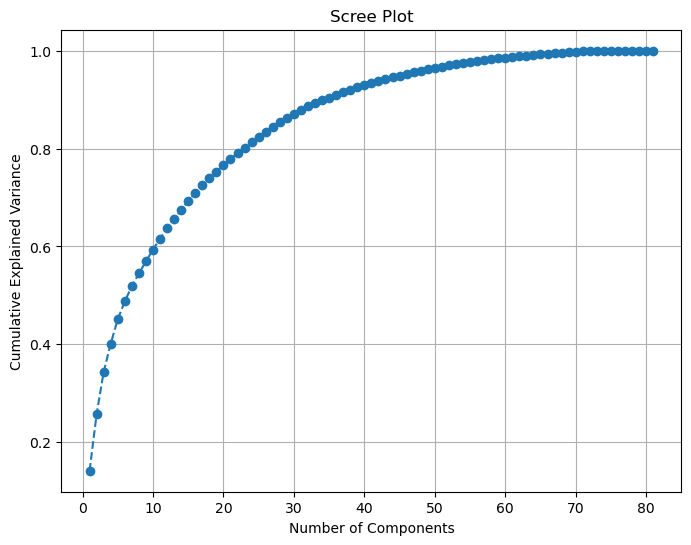

In [62]:
# Plot the scree plot to decide how many components to keep
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_arr_min_max) + 1), 
                      cumulative_variance_arr_min_max, 
                      marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [63]:
%%time
## Re-apply PCA to the data while selecting for number of components to retain.
# Apply PCA with a specific number of components
num_components = 50
pca_min_max = PCA(n_components=num_components) 
pca_result_arr_min_max = pca_min_max.fit_transform(df_process_min_max)
# Convert PCA result to DataFrame
pca_result_df_min_max = pd.DataFrame(data=pca_result_arr_min_max, columns=[f"PC{i+1}" for i in range(pca_result_arr_min_max.shape[1])])
# Explained variance ratio for each principal component
explained_var_ratio_arr_min_max = pca_min_max.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance_arr_min_max = np.cumsum(explained_var_ratio_arr_min_max)



CPU times: user 29.4 s, sys: 3.04 s, total: 32.5 s
Wall time: 12 s


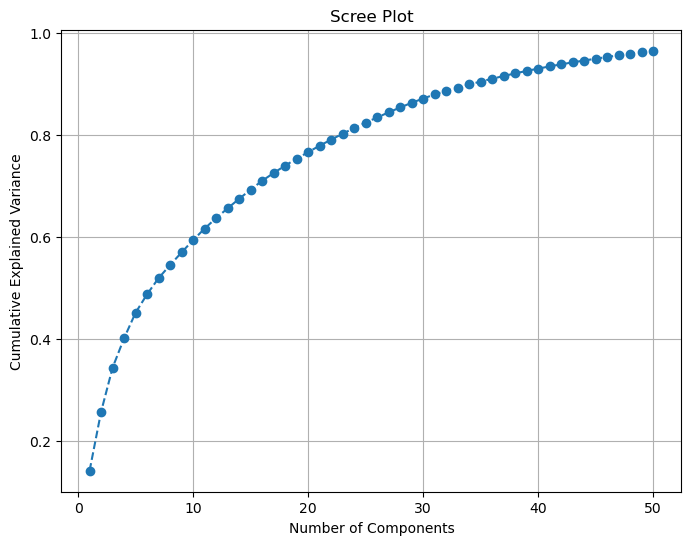

In [64]:
# Plot the scree plot to decide how many components to keep
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_arr_min_max) + 1), 
                      cumulative_variance_arr_min_max, 
                      marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

The objective of the PCA is to identify the number of principal components (PCs) that capture the greatest variability in the underline data <br>
For that objective, a scree plot was used to examine how much variablity is captured with increasing PCs. <br>
From the above analysis, 50 PCs were ultimately used.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Step 1: Access the first principal component (PC1)
first_pc_min_max = pca_min_max.components_[0]

# Step 2: Create a DataFrame linking the weights to feature names
weights_df_min_max = pd.DataFrame({'Feature': df_process_min_max.columns, 'Weight': first_pc_min_max})

# Step 3: Sort the DataFrame by the absolute values of the weights
weights_df_min_max['Absolute_Weight'] = abs(weights_df_min_max['Weight'])
weights_df_min_max_sorted = weights_df_min_max.sort_values(by='Absolute_Weight', ascending=False)

# Analysis: Print the linked values, sorted by weight
print(weights_df_min_max_sorted)

                        Feature    Weight  Absolute_Weight
2             FINANZ_MINIMALIST -0.240196         0.240196
76     CAMEO_INTL_2015_FAMILY_1  0.230886         0.230886
71      CAMEO_INTL_2015_HOUSE_1  0.222785         0.222785
3                 FINANZ_SPARER  0.211783         0.211783
36                  KBA05_ANTG1 -0.207179         0.207179
53                   PLZ8_ANTG4  0.202312         0.202312
52                   PLZ8_ANTG3  0.187402         0.187402
40                    KBA05_GBZ -0.183368         0.183368
70  PRAEGENDE_JUGENDJAHRE_GEN_6  0.182381         0.182381
28           HH_EINKOMMEN_SCORE  0.180443         0.180443
46                   MOBI_REGIO -0.177855         0.177855
42                     EWDICHTE  0.162315         0.162315
0          ALTERSKATEGORIE_GROB -0.161199         0.161199
4              FINANZ_VORSORGER -0.160717         0.160717
8              GREEN_AVANTGARDE -0.150309         0.150309
64   PRAEGENDE_JUGENDJAHRE_MOVE  0.150309         0.1503

In [66]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Step 1: Access the first principal component (PC1)
second_pc_min_max = pca_min_max.components_[1]

# Step 2: Create a DataFrame linking the weights to feature names
weights_df_min_max = pd.DataFrame({'Feature': df_process_min_max.columns, 'Weight': second_pc_min_max})

# Step 3: Sort the DataFrame by the absolute values of the weights
weights_df_min_max['Absolute_Weight'] = abs(weights_df_min_max['Weight'])
weights_df_min_max_sorted = weights_df_min_max.sort_values(by='Absolute_Weight', ascending=False)

# Analysis: Print the linked values, sorted by weight
print(weights_df_min_max_sorted)


                        Feature    Weight  Absolute_Weight
70  PRAEGENDE_JUGENDJAHRE_GEN_6 -0.266562         0.266562
3                 FINANZ_SPARER -0.225654         0.225654
6         FINANZ_UNAUFFAELLIGER -0.225009         0.225009
0          ALTERSKATEGORIE_GROB  0.222557         0.222557
4              FINANZ_VORSORGER  0.214871         0.214871
5                FINANZ_ANLEGER -0.207113         0.207113
13                    SEMIO_REL -0.201047         0.201047
10               RETOURTYP_BK_S  0.177230         0.177230
18                   SEMIO_KULT -0.176437         0.176437
17                    SEMIO_ERL  0.176135         0.176135
23                SEMIO_PFLICHT -0.174173         0.174173
24                  SEMIO_TRADV -0.173921         0.173921
16                   SEMIO_LUST  0.164703         0.164703
47            ONLINE_AFFINITAET -0.158667         0.158667
7              FINANZ_HAUSBAUER  0.150525         0.150525
71      CAMEO_INTL_2015_HOUSE_1  0.144106         0.1441

In [67]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_pc_min_max = pca_min_max.components_[2]

# Step 2: Create a DataFrame linking the weights to feature names
weights_df_min_max = pd.DataFrame({'Feature': df_process_min_max.columns, 'Weight': third_pc_min_max})

# Step 3: Sort the DataFrame by the absolute values of the weights
weights_df_min_max['Absolute_Weight'] = abs(weights_df_min_max['Weight'])
weights_df_min_max_sorted = weights_df_min_max.sort_values(by='Absolute_Weight', ascending=False)

# Analysis: Print the linked values, sorted by weight
print(weights_df_min_max_sorted)


                        Feature    Weight  Absolute_Weight
1                     ANREDE_KZ -0.540471         0.540471
15                   SEMIO_VERT  0.317641         0.317641
22                   SEMIO_KAEM -0.299331         0.299331
21                    SEMIO_DOM -0.263388         0.263388
11                    SEMIO_SOZ  0.247105         0.247105
12                    SEMIO_FAM  0.241540         0.241540
18                   SEMIO_KULT  0.239291         0.239291
20                   SEMIO_KRIT -0.226105         0.226105
5                FINANZ_ANLEGER -0.180013         0.180013
17                    SEMIO_ERL -0.171122         0.171122
19                    SEMIO_RAT -0.151903         0.151903
2             FINANZ_MINIMALIST  0.138511         0.138511
10               RETOURTYP_BK_S  0.102636         0.102636
70  PRAEGENDE_JUGENDJAHRE_GEN_6 -0.089962         0.089962
13                    SEMIO_REL  0.085037         0.085037
3                 FINANZ_SPARER -0.083547         0.0835

In [68]:
def get_pc_weights(pca_model, pc_index, feature_names):
    """
    Get the sorted weights of features for a specific principal component.
    
    Inputs:
        pca_model (PCA): The trained PCA model.
        pc_index (int): The index of the principal component.
        feature_names (list): List of feature names.
        
    Outputs:
        pd.DataFrame: DataFrame containing sorted feature weights for the principal component.
    """
    pc_weights = pca_model.components_[pc_index]
    
    weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': pc_weights})
    weights_df['Absolute_Weight'] = abs(weights_df['Weight'])
    weights_df_sorted = weights_df.sort_values(by='Absolute_Weight', ascending=False)
    
    return weights_df_sorted

In [69]:
second_pc_weights_min_max = get_pc_weights(pca_min_max, pc_index=1, feature_names=df_process_min_max.columns)
print(second_pc_weights_min_max)

                        Feature    Weight  Absolute_Weight
70  PRAEGENDE_JUGENDJAHRE_GEN_6 -0.266562         0.266562
3                 FINANZ_SPARER -0.225654         0.225654
6         FINANZ_UNAUFFAELLIGER -0.225009         0.225009
0          ALTERSKATEGORIE_GROB  0.222557         0.222557
4              FINANZ_VORSORGER  0.214871         0.214871
5                FINANZ_ANLEGER -0.207113         0.207113
13                    SEMIO_REL -0.201047         0.201047
10               RETOURTYP_BK_S  0.177230         0.177230
18                   SEMIO_KULT -0.176437         0.176437
17                    SEMIO_ERL  0.176135         0.176135
23                SEMIO_PFLICHT -0.174173         0.174173
24                  SEMIO_TRADV -0.173921         0.173921
16                   SEMIO_LUST  0.164703         0.164703
47            ONLINE_AFFINITAET -0.158667         0.158667
7              FINANZ_HAUSBAUER  0.150525         0.150525
71      CAMEO_INTL_2015_HOUSE_1  0.144106         0.1441

In [70]:
def plot_pc_weights(pca_model, feature_names, pc_idx, num_features=10):
    """
    Plot the weights of features for a principal component.
    
    Input:
        pca_model (PCA): The trained PCA model.
        feature_names (list): List of feature names.
        pc_idx (int): Index of the principal component to plot.
        num_features (int): Number of top features to plot.
    Output:
        None
    """
    pc_weights = pca_model.components_[pc_idx]
    pc_weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': pc_weights})
    pc_weights_df['Absolute_Weight'] = abs(pc_weights_df['Weight'])
    pc_weights_df_sorted = pc_weights_df.sort_values(by='Absolute_Weight', ascending=False)
    top_features = pc_weights_df_sorted['Feature'][:num_features]
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, pc_weights_df_sorted['Weight'][:num_features])
    plt.xlabel('Weight')
    plt.ylabel('Feature')
    plt.title(f'Principal Component {pc_idx + 1} - Top Features')
    plt.tight_layout()
    plt.show()

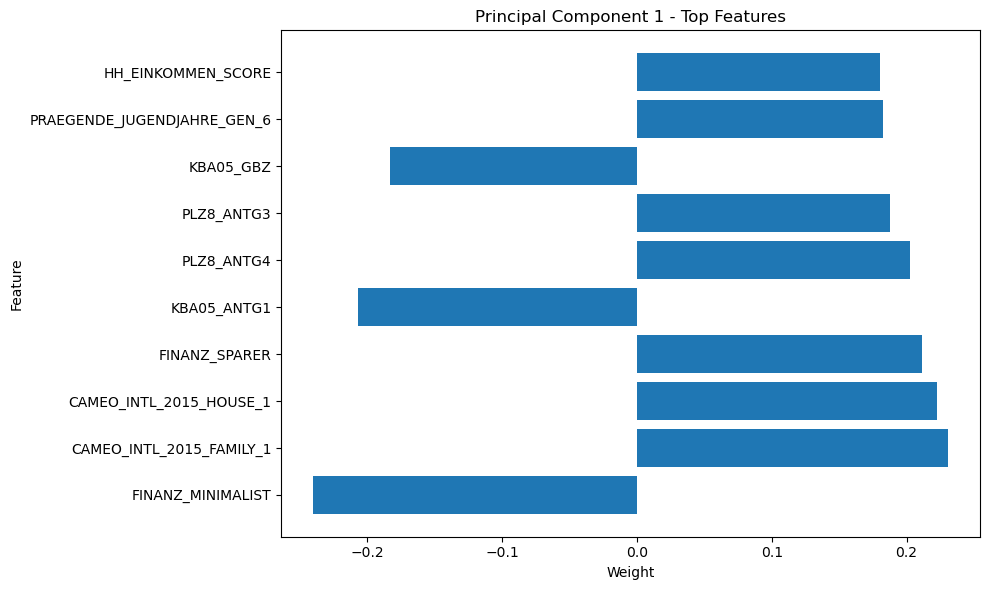

In [71]:
plot_pc_weights(pca_min_max, feature_names=df_process_min_max.columns, pc_idx=0, num_features=10)


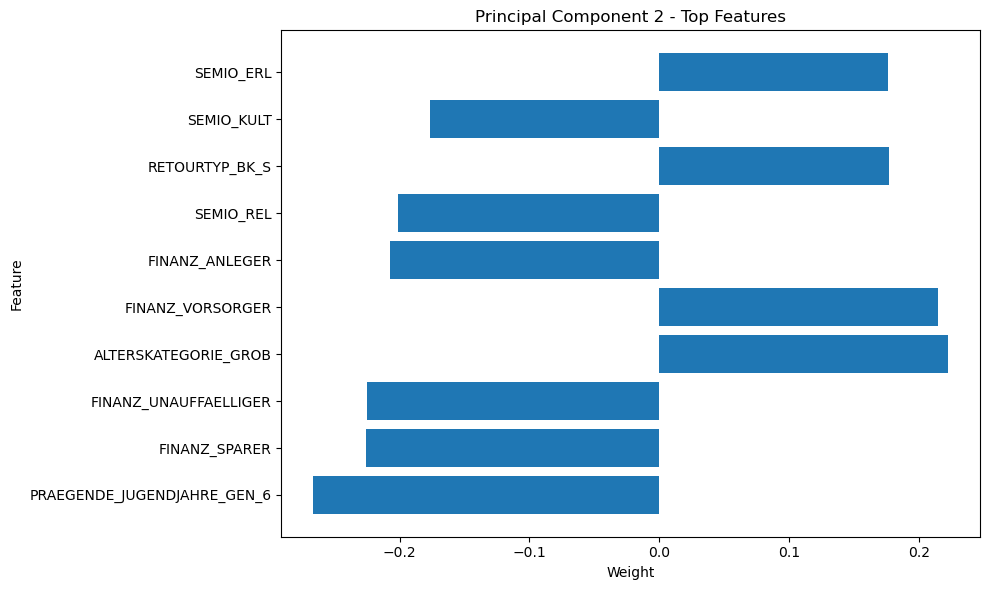

In [72]:
plot_pc_weights(pca_min_max, feature_names=df_process_min_max.columns, pc_idx=1, num_features=10)


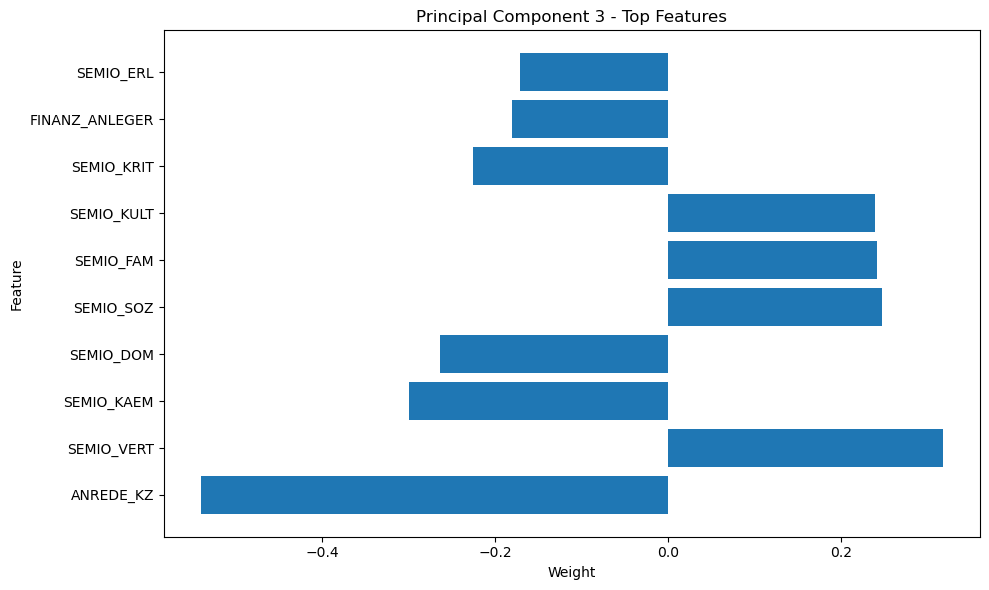

In [73]:
plot_pc_weights(pca_min_max, feature_names=df_process_min_max.columns, pc_idx=2, num_features=10)


### Discussion 2.3: Interpret Principal Components
After selecting 50 PCs, there were several top features which defined the cohorts:
- PRAEGENDE_JUGENDJAHRE: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- FINANZ_SPARER: Financial typology, specifically the money-saving dimension
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- FINANZ_UNAUFFAELLIGER: Financial typology, specifically the inconspicuous dimension
- FINANZ_ANLEGER: Financial typology, specifically the investor dimension
- SEMIO_REL: Personality typology, specifically the religious dimension:

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [73]:
# Step 1: Perform k-means clustering on the transformed data
num_clusters = 3  # Choose the number of clusters you want
kmeans_min_max = KMeans(n_clusters=num_clusters)
kmeans_min_max.fit(pca_result_arr_min_max)

# Get the cluster labels for each data point
cluster_labels_min_max = kmeans_min_max.labels_

# Add the cluster labels to the original DataFrame
df_process_min_max['Cluster Min Max'] = cluster_labels_min_max

# You can now analyze the clustered data and use it for further analysis.
display(df_process_min_max.head())


/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5,Cluster Min Max
0,0.000000,1.0,0.00,1.00,0.25,1.00,0.75,1.00,0.0,1.0,0.00,0.666667,0.5,0.500000,0.333333,0.000000,0.166667,0.166667,0.333333,0.833333,0.500000,1.000000,0.500000,1.000000,0.833333,1.0,0.044444,0.0,1.0,0.400000,1.0,0.016835,0.0,0.000000,0.225806,0.0,0.00,0.00,0.000000,1.0,0.00,0.833333,0.4,1.000000,0.50,0.333333,0.0,0.6,0.333333,0.418696,0.50,0.75,0.666667,0.5,1.00,0.75,0.50,0.500,0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
1,0.666667,1.0,0.00,0.75,0.00,0.25,0.50,1.00,1.0,1.0,0.50,0.500000,0.0,0.333333,0.333333,0.500000,0.500000,0.833333,0.333333,0.500000,1.000000,1.000000,1.000000,0.333333,0.333333,0.0,0.022222,0.0,0.6,0.400000,1.0,0.015152,0.0,0.666667,0.225806,0.0,0.25,0.75,0.333333,0.0,0.50,0.166667,0.6,0.428571,0.75,0.333333,0.4,0.4,0.166667,0.309565,0.75,0.75,0.333333,0.0,0.75,0.75,0.50,0.500,0.25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,1.000000,1.0,0.75,0.25,1.00,0.25,0.00,0.25,0.0,0.5,0.25,0.666667,0.0,0.166667,0.000000,0.500000,0.500000,1.000000,0.500000,0.333333,0.500000,0.500000,0.666667,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.632411,1.0,0.000000,0.0,0.500000,0.387097,0.0,1.00,0.25,0.000000,0.0,0.75,0.500000,0.2,0.714286,0.75,0.574475,0.6,0.2,0.578694,0.259130,0.50,0.50,0.666667,0.0,0.50,0.75,0.25,0.250,0.50,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
3,0.666667,0.0,0.75,0.50,0.75,0.00,0.50,0.25,0.0,1.0,1.00,0.833333,0.5,0.500000,0.166667,1.000000,0.500000,0.500000,0.833333,0.166667,0.333333,0.166667,0.166667,0.500000,0.166667,0.0,0.088889,0.0,0.8,0.200000,1.0,0.003367,0.0,0.500000,0.225806,0.0,0.25,1.00,0.333333,0.0,0.50,0.166667,0.8,0.000000,1.00,0.666667,0.4,1.0,0.666667,0.189130,0.50,1.00,0.666667,0.5,0.50,0.50,0.75,0.625,1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.000000,1.0,0.50,0.00,1.00,0.25,0.25,1.00,0.0,1.0,0.50,0.166667,0.5,1.000000,0.500000,0.166667,0.166667,0.166667,0.666667,1.000000,0.500000,0.500000,0.500000,1.000000,0.833333,0.0,0.022222,0.0,0.8,1.000000,1.0,0.006734,0.0,0.666667,0.225806,0.0,0.50,0.50,0.000000,0.0,0.75,0.833333,0.2,0.857143,0.75,1.000000,0.6,0.2,0.666667,0.565217,0.50,0.75,0.333333,0.5,1.00,1.00,0.25,0.250,0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


In [74]:
# Assuming you have already performed k-means clustering and have the 'kmeans' object

# Get the cluster centers
cluster_centers_min_max = kmeans_min_max.cluster_centers_

# Use the transform method to get the distances of each point to the cluster centers
distances_to_centers = kmeans_min_max.transform(pca_result_arr_min_max)


# Calculate the average distance for each cluster
average_distances = np.mean(distances_to_centers, axis=0)

# Print the average distance for each cluster
for i, avg_distance in enumerate(average_distances):
    print(f"Average distance for Cluster {i}: {avg_distance}")


Average distance for Cluster 0: 3.1076715609953287
Average distance for Cluster 1: 3.0701918501792105
Average distance for Cluster 2: 3.136935683676325


In [75]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [76]:
def kmeans_clustering(X, max_clusters):
    '''
    Input: X: The array containing samples to be clustered (ideally normalized data)
           max_cluster: The maximum number of clusters to investigate
    Output: k_values: The array of the KMeans values
            mean_avg_distances: The array of mean average distance among clusters
            wall_times: The array of times it takes to perform KMeans clustering

    '''
    k_values = []
    mean_avg_distances = []
    wall_times = []

    for k in range(1, max_clusters + 1):
        start_time = time.time()

        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        
        wall_time = time.time() - start_time

        k_values.append(k)
        mean_avg_distance = np.mean(np.min(kmeans.transform(X), axis=1))
        mean_avg_distances.append(mean_avg_distance)
        wall_times.append(wall_time)

    return k_values, mean_avg_distances, wall_times

In [23]:
%%time
## Step 1: Run kmeans_clustering function for multiple cluster numbers [2, max_clusters]
#         to get the following
#          - mean_avg_distances among cluster
#          - time required to calculate how long KMeans takes for each cluster number 
#
k_values, mean_avg_distances, wall_times =\
    kmeans_clustering(X=pca_result_arr_min_max, max_clusters=20)



/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/con

CPU times: user 29min 53s, sys: 23.5 s, total: 30min 16s
Wall time: 5min 17s


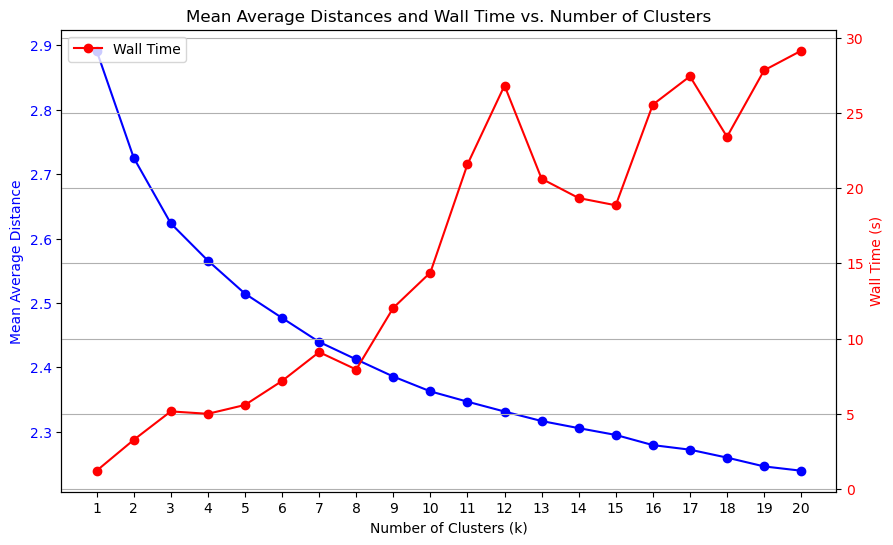

In [24]:
## Step 2a: As a function of cluster number, plot
##         - mean average distances among clusters
##         - wall times
#
# Plot the mean average distances and wall times
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(k_values, mean_avg_distances, label='Mean Average Distances', marker='o', color='b')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Mean Average Distance', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a new y-axis on the right side for the wall times
ax2 = ax1.twinx()
ax2.plot(k_values, wall_times, label='Wall Time', marker='o', color='r')
ax2.set_ylabel('Wall Time (s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set titles and legend
plt.title('Mean Average Distances and Wall Time vs. Number of Clusters')
plt.legend(loc='upper left')

# Manually set the x-axis tick locations to match the k_values
plt.xticks(k_values)

plt.grid()
plt.show()

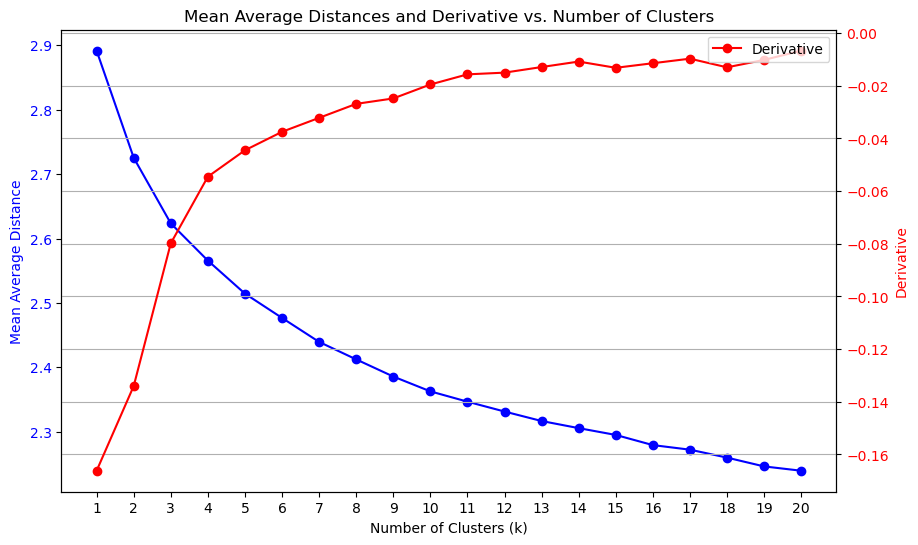

In [25]:
## Step 2b: As a funciton of cluster number, plot
#          - mean average distances among clusters
#          - the derivative (rate of change of the mean average distances
#
# Calculate the derivative (rate of change) of the mean average distances
derivative_mean_avg_distances = np.gradient(mean_avg_distances, k_values)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(k_values, mean_avg_distances, label='Mean Average Distances', marker='o', color='b')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Mean Average Distance', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a new y-axis on the right side for the derivative
ax2 = ax1.twinx()
ax2.plot(k_values, derivative_mean_avg_distances, label='Derivative', marker='o', color='r')
ax2.set_ylabel('Derivative', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set titles and legend
plt.title('Mean Average Distances and Derivative vs. Number of Clusters')
plt.legend(loc='upper right')

# Manually set the x-axis tick locations to match the k_values
plt.xticks(k_values)

plt.grid()
plt.show()

Note that while the elbow time seems to be around 10 or 11 clusters, the time required to perform KMeans high (50, 27 seconds, respectively), so a decision was made to use 13 clusters which while providing incremental improvement over the mean average distance, allows for faster KMeans calculations at 15 seconds.

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



In [26]:
%%time
# Step 1: Perform k-means clustering on the transformed data
num_clusters = 13  # Choose the number of clusters you want
kmeans_min_max = KMeans(n_clusters=num_clusters)
kmeans_min_max.fit(pca_result_arr_min_max)

# Get the cluster labels for each data point
cluster_labels_min_max = kmeans_min_max.labels_

# Add the cluster labels to the original DataFrame
df_process_min_max['Cluster Min Max'] = cluster_labels_min_max

# You can now analyze the clustered data and use it for further analysis.
display(df_process_min_max.head())

# Get the cluster centers
cluster_centers_min_max = kmeans_min_max.cluster_centers_

# Use the transform method to get the distances of each point to the cluster centers
distances_to_centers = kmeans_min_max.transform(pca_result_arr_min_max)


# Calculate the average distance for each cluster
average_distances = np.mean(distances_to_centers, axis=0)

# Print the average distance for each cluster
for i, avg_distance in enumerate(average_distances):
    print(f"Average distance for Cluster {i}: {avg_distance}")



/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5,Cluster Min Max
0,0.000000,1.0,0.00,1.00,0.25,1.00,0.75,1.00,0.0,1.0,0.00,0.666667,0.5,0.500000,0.333333,0.000000,0.166667,0.166667,0.333333,0.833333,0.500000,1.000000,0.500000,1.000000,0.833333,1.0,0.044444,0.0,1.0,0.400000,1.0,0.016835,0.0,0.000000,0.28,0.0,0.00,0.00,0.000000,1.0,0.00,0.833333,0.4,1.000000,0.50,0.333333,0.0,0.6,0.333333,0.418696,0.50,0.75,0.666667,0.5,1.00,0.75,0.50,0.500,0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,0.666667,1.0,0.00,0.75,0.00,0.25,0.50,1.00,1.0,1.0,0.50,0.500000,0.0,0.333333,0.333333,0.500000,0.500000,0.833333,0.333333,0.500000,1.000000,1.000000,1.000000,0.333333,0.333333,0.0,0.022222,0.0,0.6,0.400000,1.0,0.015152,0.0,0.666667,0.28,0.0,0.25,0.75,0.333333,0.0,0.50,0.166667,0.6,0.428571,0.75,0.333333,0.4,0.4,0.166667,0.309565,0.75,0.75,0.333333,0.0,0.75,0.75,0.50,0.500,0.25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10
2,1.000000,1.0,0.75,0.25,1.00,0.25,0.00,0.25,0.0,0.5,0.25,0.666667,0.0,0.166667,0.000000,0.500000,0.500000,1.000000,0.500000,0.333333,0.500000,0.500000,0.666667,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.634894,1.0,0.000000,0.0,0.500000,0.48,0.0,1.00,0.25,0.000000,0.0,0.75,0.500000,0.2,0.714286,0.75,0.575177,0.6,0.2,0.579284,0.259130,0.50,0.50,0.666667,0.0,0.50,0.75,0.25,0.250,0.50,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4
3,0.666667,0.0,0.75,0.50,0.75,0.00,0.50,0.25,0.0,1.0,1.00,0.833333,0.5,0.500000,0.166667,1.000000,0.500000,0.500000,0.833333,0.166667,0.333333,0.166667,0.166667,0.500000,0.166667,0.0,0.088889,0.0,0.8,0.200000,1.0,0.003367,0.0,0.500000,0.28,0.0,0.25,1.00,0.333333,0.0,0.50,0.166667,0.8,0.000000,1.00,0.666667,0.4,1.0,0.666667,0.189130,0.50,1.00,0.666667,0.5,0.50,0.50,0.75,0.625,1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12
4,0.000000,1.0,0.50,0.00,1.00,0.25,0.25,1.00,0.0,1.0,0.50,0.166667,0.5,1.000000,0.500000,0.166667,0.166667,0.166667,0.666667,1.000000,0.500000,0.500000,0.500000,1.000000,0.833333,0.0,0.022222,0.0,0.8,1.000000,1.0,0.006734,0.0,0.666667,0.28,0.0,0.50,0.50,0.000000,0.0,0.75,0.833333,0.2,0.857143,0.75,1.000000,0.6,0.2,0.666667,0.565217,0.50,0.75,0.333333,0.5,1.00,1.00,0.25,0.250,0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6


Average distance for Cluster 0: 3.476836442244966
Average distance for Cluster 1: 3.2113917054923005
Average distance for Cluster 2: 3.3862292218585686
Average distance for Cluster 3: 3.2363066587493132
Average distance for Cluster 4: 3.2320170887333766
Average distance for Cluster 5: 3.3677992989356627
Average distance for Cluster 6: 3.2936054238048365
Average distance for Cluster 7: 3.3229372502322985
Average distance for Cluster 8: 3.376115971400829
Average distance for Cluster 9: 3.3984183820172467
Average distance for Cluster 10: 3.3857676417262317
Average distance for Cluster 11: 3.4462697995867373
Average distance for Cluster 12: 3.248929115734657
CPU times: user 1min 11s, sys: 873 ms, total: 1min 11s
Wall time: 12.6 s


### Discussion 3.1: Apply Clustering to General Population

For clustering, I examined wall-time in addition to the rate of change as a function of the number of clusters. <br>
For more precision, I used the derivative of the mean average distance of the points in a each cluster as a way to identify the "elbow" of the curve. <br>
Also useful for production deployment, the wall-time was used to identify the number of clusters which required a shorter time for convergence. <br>
Ultimately, 13 clusters were chosen.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [31]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")


In [29]:
display(df_process_customers.head())
df_process_customers.shape

NameError: name 'df_process_customers' is not defined

In [32]:
%%time
## Apply preprocessing, feature transformation, and clustering from the general
## demographics onto the customer data, obtaining cluster predictions for the
## customer demographics data.
## PROCESSING
df_process_customers = clean_data(customers)

## NAN REPLACEMENT
# Identify columns with missing values
cols_with_missing_values = df_process_customers.columns[df_process.isna().any()].tolist()

# IMPUTE MISSING VALUES BASED ON DATA TYPE
for col in cols_with_missing_values:
    if df_process_customers[col].dtype == 'float64':
        # For numeric columns, use mean imputation
        df_process_customers[col].fillna(df_process_customers[col].mean(), inplace=True)
    else:
        # For categorical columns, use mode imputation
        df_process_customers[col].fillna(df_process_customers[col].mode().iloc[0], inplace=True)

## APPLY FEATURE SCALING
# Min-Max scaling
# min_max_scaler = MinMaxScaler() # Don't use a new scaling
# arr_process_min_max_customer = min_max_scaler.fit_transform(df_process_customers) # Don't use a new scaling
arr_process_min_max_customer = min_max_scaler.transform(df_process_customers)

# Standardization Won't use in this round
# standard_scaler = StandardScaler() # Don't use a new scaling, use the previous for geneneral population
#arr_process_standard = standard_scaler.fit_transform(df_process)

# Convert the scaled arrays back to DataFrames
df_process_min_max_customer = pd.DataFrame(arr_process_min_max_customer, columns=df_process_customers.columns)
#df_process_scaled_standard = pd.DataFrame(arr_process_standard, columns=df_process.columns)


## PCA
# Apply  Re-apply PCA to the data while selecting for number of components to retain.
# Apply PCA with a specific number of components
# num_components = 50
# pca_min_max = PCA(n_components=num_components) # Don't use a new pca
# pca_result_arr_min_max_customer = pca_min_max.fit_transform(df_process_min_max_customer) # Don't use a new pca
pca_result_arr_min_max_customer = pca_min_max.transform(df_process_min_max_customer)

# Convert PCA result to DataFrame
pca_result_df_min_max_customer = pd.DataFrame(data=pca_result_arr_min_max_customer, 
                                     columns=[f"PC{i+1}" for i in range(pca_result_arr_min_max_customer.shape[1])])
# Explained variance ratio for each principal component
explained_var_ratio_arr_min_max_customer = pca_result_arr_min_max_customer.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance_arr_min_max = np.cumsum(explained_var_ratio_arr_min_max_customer)


## Cluster
# Perform k-means clustering on the transformed customer data
#num_clusters = 13  # Choose the same number of clusters as for the previous general populuation
#kmeans_min_max = KMeans(n_clusters=num_clusters) #Use a new cluster
#kmeans_min_max.fit(pca_result_df_min_max)
# Get the cluster labels for each data point
# cluster_labels_min_max = kmeans_min_max.labels_

cluster_labels_min_max_customer = kmeans_min_max.predict(pca_result_df_min_max_customer)

# Add the cluster labels to the original DataFrame
df_process_min_max_customer['Cluster Min Max'] = cluster_labels_min_max_customer

# You can now analyze the clustered data and use it for further analysis.
display(df_process_min_max.head())

# Get the cluster centers
#cluster_centers_min_max = kmeans_min_max.cluster_centers_
# Get the cluster centers for the subset data
cluster_centers_customer = kmeans_min_max.cluster_centers_[cluster_labels_min_max_customer]

# Use the transform method to get the distances of each point to the cluster centers
#distances_to_centers = kmeans_min_max.transform(pca_result_df_min_max_customer)
distances_to_centers_customer = kmeans_min_max.transform(pca_result_df_min_max_customer)


# Calculate the average distance for each cluster
# average_distances = np.mean(distances_to_centers, axis=0)
average_distances_customer = np.mean(distances_to_centers_customer, axis=0)

# Print the average distance for each cluster
# for i, avg_distance in enumerate(average_distances):
#     print(f"Average distance for Cluster {i}: {avg_distance}")
for i, avg_distance in enumerate(average_distances_customer):
    print(f"Average distance for Cluster {i}: {avg_distance}")

Error: malformed node or string: <ast.Name object at 0x7fbb573604c0> for [-1,X] will replace with 'X'
Skipping ANREDE_KZ. Cardinality: 2
Skipping GREEN_AVANTGARDE. Cardinality: 2
The column NATIONALITAET_KZ does not exist.
Skipping SOHO_KZ. Cardinality: 2
The column VERS_TYP does not exist.
Skipping OST_WEST_KZ. Cardinality: 2
unique_values: [2 1 4 3 6 5 <NA>]
length: 7
unique_values: [5 3 4 2 1 <NA>]
length: 6
unique_values: [3 4 1 5 2 <NA>]
length: 6


<ipython-input-5-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
<ipython-input-5-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
<ipython-input-5-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 1325, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 24, in <module>
  File "/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/preprocessing/_data.py", line 508, in transform
    X = self._validate_data(
  File "/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/base.py", line 535, in _validate_data
    X = check_array(X, input_name="X", **check_params)
  File "/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/utils/validation.py", line 877, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/utils/_array_api.py", line 185, in _as

In [ ]:
df_process_customers.

In [33]:
nan_percent = df_process_customers.isna().mean().sort_values()
data_types = df_process.dtypes
nan_data_types_df = pd.DataFrame({
    'NaN Percentage': nan_percent,
    'Data Type': data_types
})
nan_data_types_df.sort_values(by='NaN Percentage', ascending=False)

,NaN Percentage,Data Type
REGIOTYP,0.062025,float64
KKK,0.062025,float64
W_KEIT_KIND_HH,0.052975,float64
KBA05_GBZ,0.027033,float64
MOBI_REGIO,0.027018,float64
KBA05_ANTG2,0.027018,float64
KBA05_ANTG3,0.027018,float64
KBA05_ANTG4,0.027018,float64
KBA05_ANTG1,0.027018,float64
ANZ_HAUSHALTE_AKTIV,0.015390,float64


In [34]:
%%time
## Apply preprocessing, feature transformation, and clustering from the general
## demographics onto the customer data, obtaining cluster predictions for the
## customer demographics data.
## PROCESSING
df_process_customers = clean_data(customers)

## NAN REPLACEMENT
# Identify columns with missing values
cols_with_missing_values =\
    df_process_customers.columns[df_process_customers.isna().any()].tolist()

# IMPUTE MISSING VALUES BASED ON DATA TYPE
for col in cols_with_missing_values:
    if df_process_customers[col].dtype == 'float64':
        # For numeric columns, use mean imputation
        df_process_customers[col].fillna(df_process_customers[col].mean(), 
                                         inplace=True)
    else:
        # For categorical columns, use mode imputation
        df_process_customers[col].fillna(df_process_customers[col].mode().iloc[0], 
                                         inplace=True)

## APPLY FEATURE SCALING with instance of min_max_scaler previously defined.
arr_process_min_max_customer = min_max_scaler.transform(df_process_customers)

# Convert the scaled arrays back to DataFrames
df_process_min_max_customer = pd.DataFrame(arr_process_min_max_customer, columns=df_process_customers.columns)

## PCA
# Apply  Re-apply PCA to the data with 50 components.
pca_result_arr_min_max_customer = pca_min_max.transform(df_process_min_max_customer)

# Convert PCA result to DataFrame
pca_result_df_min_max_customer =\
    pd.DataFrame(data=pca_result_arr_min_max_customer, 
                 columns=[f"PC{i+1}" for i in range(pca_result_arr_min_max_customer.shape[1])])
# Explained variance ratio for each principal component Don't need as it is model specific
explained_var_ratio_arr_min_max_customer =\
    pca_min_max.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance_arr_min_max =\
    np.cumsum(explained_var_ratio_arr_min_max_customer)

## Cluster
# Perform k-means clustering on the transformed customer data with num_clusters = 13
# from previously trained KMeans model.
cluster_labels_min_max_customer = kmeans_min_max.predict(pca_result_df_min_max_customer)

# Add the cluster labels to the original DataFrame
df_process_min_max_customer['Cluster Min Max'] = cluster_labels_min_max_customer

# You can now analyze the clustered data and use it for further analysis.
display(df_process_min_max.head())

# Get the cluster centers
#cluster_centers_min_max = kmeans_min_max.cluster_centers_
# Get the cluster centers for the subset data
cluster_centers_customer = kmeans_min_max.cluster_centers_[cluster_labels_min_max_customer]

# Use the transform method to get the distances of each point to the cluster centers
#distances_to_centers = kmeans_min_max.transform(pca_result_df_min_max_customer)
distances_to_centers_customer = kmeans_min_max.transform(pca_result_df_min_max_customer)


# Calculate the average distance for each customer cluster
average_distances_customer = np.mean(distances_to_centers_customer, axis=0)

# Print the average distance for each customer cluster
for i, avg_distance in enumerate(average_distances_customer):
    print(f"Average distance for Cluster {i}: {avg_distance}")

Error: malformed node or string: <ast.Name object at 0x7fbab96c5a60> for [-1,X] will replace with 'X'
Skipping ANREDE_KZ. Cardinality: 2
Skipping GREEN_AVANTGARDE. Cardinality: 2
The column NATIONALITAET_KZ does not exist.
Skipping SOHO_KZ. Cardinality: 2
The column VERS_TYP does not exist.
Skipping OST_WEST_KZ. Cardinality: 2
unique_values: [2 1 4 3 6 5 <NA>]
length: 7
unique_values: [5 3 4 2 1 <NA>]
length: 6
unique_values: [3 4 1 5 2 <NA>]
length: 6


<ipython-input-5-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
<ipython-input-5-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
<ipython-input-5-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5,Cluster Min Max
0,0.000000,1.0,0.00,1.00,0.25,1.00,0.75,1.00,0.0,1.0,0.00,0.666667,0.5,0.500000,0.333333,0.000000,0.166667,0.166667,0.333333,0.833333,0.500000,1.000000,0.500000,1.000000,0.833333,1.0,0.044444,0.0,1.0,0.400000,1.0,0.016835,0.0,0.000000,0.28,0.0,0.00,0.00,0.000000,1.0,0.00,0.833333,0.4,1.000000,0.50,0.333333,0.0,0.6,0.333333,0.418696,0.50,0.75,0.666667,0.5,1.00,0.75,0.50,0.500,0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,0.666667,1.0,0.00,0.75,0.00,0.25,0.50,1.00,1.0,1.0,0.50,0.500000,0.0,0.333333,0.333333,0.500000,0.500000,0.833333,0.333333,0.500000,1.000000,1.000000,1.000000,0.333333,0.333333,0.0,0.022222,0.0,0.6,0.400000,1.0,0.015152,0.0,0.666667,0.28,0.0,0.25,0.75,0.333333,0.0,0.50,0.166667,0.6,0.428571,0.75,0.333333,0.4,0.4,0.166667,0.309565,0.75,0.75,0.333333,0.0,0.75,0.75,0.50,0.500,0.25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10
2,1.000000,1.0,0.75,0.25,1.00,0.25,0.00,0.25,0.0,0.5,0.25,0.666667,0.0,0.166667,0.000000,0.500000,0.500000,1.000000,0.500000,0.333333,0.500000,0.500000,0.666667,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.634894,1.0,0.000000,0.0,0.500000,0.48,0.0,1.00,0.25,0.000000,0.0,0.75,0.500000,0.2,0.714286,0.75,0.575177,0.6,0.2,0.579284,0.259130,0.50,0.50,0.666667,0.0,0.50,0.75,0.25,0.250,0.50,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4
3,0.666667,0.0,0.75,0.50,0.75,0.00,0.50,0.25,0.0,1.0,1.00,0.833333,0.5,0.500000,0.166667,1.000000,0.500000,0.500000,0.833333,0.166667,0.333333,0.166667,0.166667,0.500000,0.166667,0.0,0.088889,0.0,0.8,0.200000,1.0,0.003367,0.0,0.500000,0.28,0.0,0.25,1.00,0.333333,0.0,0.50,0.166667,0.8,0.000000,1.00,0.666667,0.4,1.0,0.666667,0.189130,0.50,1.00,0.666667,0.5,0.50,0.50,0.75,0.625,1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12
4,0.000000,1.0,0.50,0.00,1.00,0.25,0.25,1.00,0.0,1.0,0.50,0.166667,0.5,1.000000,0.500000,0.166667,0.166667,0.166667,0.666667,1.000000,0.500000,0.500000,0.500000,1.000000,0.833333,0.0,0.022222,0.0,0.8,1.000000,1.0,0.006734,0.0,0.666667,0.28,0.0,0.50,0.50,0.000000,0.0,0.75,0.833333,0.2,0.857143,0.75,1.000000,0.6,0.2,0.666667,0.565217,0.50,0.75,0.333333,0.5,1.00,1.00,0.25,0.250,0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6


Average distance for Cluster 0: 4.01518559065857
Average distance for Cluster 1: 2.9156688105334783
Average distance for Cluster 2: 2.8341462389812153
Average distance for Cluster 3: 3.440145470966152
Average distance for Cluster 4: 3.079253832524394
Average distance for Cluster 5: 3.468465268563331
Average distance for Cluster 6: 3.5440653574305445
Average distance for Cluster 7: 3.12222310110654
Average distance for Cluster 8: 3.8768787043608053
Average distance for Cluster 9: 3.350675134844334
Average distance for Cluster 10: 3.0108512838564283
Average distance for Cluster 11: 3.840314996891106
Average distance for Cluster 12: 3.2977093813435796
CPU times: user 10.6 s, sys: 310 ms, total: 10.9 s
Wall time: 10.3 s


/opt/conda/envs/p39_arvato/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [78]:
cluster_centers_customer

array([[-1.26073042,  0.25947685,  0.95577163, ...,  0.01866836,
        -0.02170961,  0.01225116],
       [-1.32603414, -0.23661046, -0.63305814, ..., -0.01226506,
         0.01258108, -0.00349798],
       [-1.04496671,  0.20923477,  0.67271349, ...,  0.01942481,
        -0.0272902 ,  0.00185604],
       ...,
       [-1.26073042,  0.25947685,  0.95577163, ...,  0.01866836,
        -0.02170961,  0.01225116],
       [-1.10760755, -0.28107053, -0.81198216, ..., -0.00993168,
         0.01063029, -0.00258736],
       [-1.04496671,  0.20923477,  0.67271349, ...,  0.01942481,
        -0.0272902 ,  0.00185604]])

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



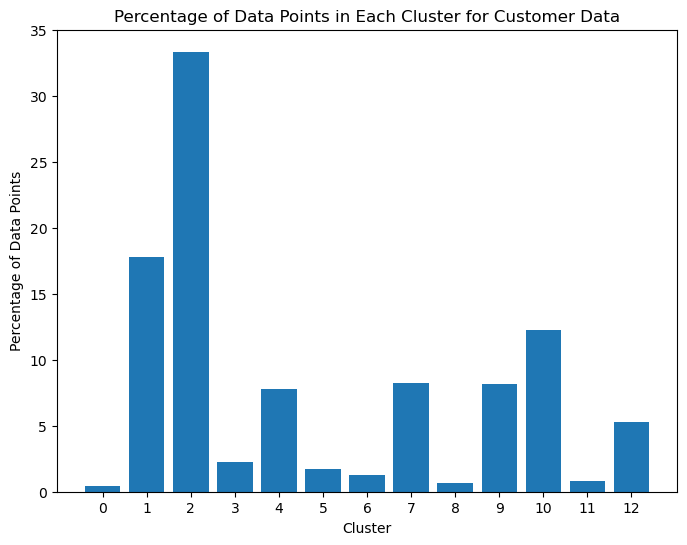

2     33.347079
1     17.777745
10    12.237940
7      8.226128
9      8.175318
4      7.811545
12     5.259243
3      2.236393
5      1.691470
6      1.304870
11     0.785720
8      0.689254
0      0.457293
Name: Cluster Min Max, dtype: float64


In [66]:
# Count the number of data points in each cluster for customer data
cluster_counts = df_process_min_max_customer['Cluster Min Max'].value_counts()

# Calculate the percentage of data points in each cluster
cluster_percentages = cluster_counts / len(df_process_min_max_customer) * 100

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_percentages)
plt.xlabel('Cluster')
plt.ylabel('Percentage of Data Points')
plt.title('Percentage of Data Points in Each Cluster for Customer Data')
plt.xticks(cluster_counts.index)
plt.show()
print(cluster_percentages)

customer_percentages = cluster_percentages.values
customer_percentages_index = cluster_percentages.index

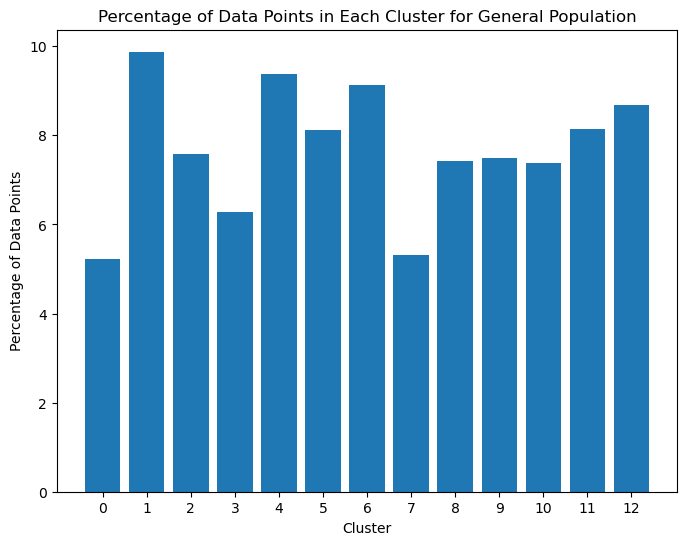

1     9.875327
4     9.381094
6     9.137477
12    8.686136
11    8.149011
5     8.119725
2     7.577935
9     7.486449
8     7.415437
10    7.366972
3     6.287150
7     5.303868
0     5.213418
Name: Cluster Min Max, dtype: float64


In [68]:
# Count the number of data points in each cluster for general population data
cluster_counts = df_process_min_max['Cluster Min Max'].value_counts()

# Calculate the percentage of data points in each cluster
cluster_percentages = cluster_counts / len(df_process_min_max) * 100

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_percentages)
plt.xlabel('Cluster')
plt.ylabel('Percentage of Data Points')
plt.title('Percentage of Data Points in Each Cluster for General Population')
plt.xticks(cluster_counts.index)
plt.show()
print(cluster_percentages)

general_population_percentages = cluster_percentages.values
general_population_percentages_index = cluster_percentages.index

In [77]:
# Cluster numbers for customer and general population

# Reorder customer percentages and cluster numbers to match general population order
reordered_customer_percentages = [customer_percentages[np.where(customer_percentages_index == c)[0][0]] for c in general_population_cluster_numbers]

# Calculate the percentage difference
percentage_difference = (reordered_customer_percentages - general_population_percentages) / general_population_percentages * 100

# Find the most overrepresented and underrepresented clusters
most_overrepresented_cluster = general_population_cluster_numbers[np.argmax(percentage_difference)]
most_underrepresented_cluster = general_population_cluster_numbers[np.argmin(percentage_difference)]

print(f"Most Overrepresented Cluster: {most_overrepresented_cluster}")
print(f"Percentage Difference: {percentage_difference[np.argmax(percentage_difference)]:.2f}%")

print(f"Most Underrepresented Cluster: {most_underrepresented_cluster}")
print(f"Percentage Difference: {percentage_difference[np.argmin(percentage_difference)]:.2f}%")

Most Overrepresented Cluster: 2
Percentage Difference: 340.05%
Most Underrepresented Cluster: 0
Percentage Difference: -91.23%


In [37]:
# Get the cluster centers for the subset data
cluster_centers_customer = kmeans_min_max.cluster_centers_[cluster_labels_min_max_customer]
cluster_centers_customer
# Inverse transform the cluster centers to get the original feature space
original_cluster_centers = pca_min_max.inverse_transform(cluster_centers_customer)

# Create a DataFrame to store the original cluster centers with feature names
df_original_cluster_centers = pd.DataFrame(data=original_cluster_centers, columns=df_process_customers.columns)

# Print the original cluster centers with feature names
display(df_original_cluster_centers)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
0,0.753831,0.010999,0.946762,0.167199,0.801863,0.140048,0.288717,0.228591,0.999287,0.544124,0.746351,0.662238,0.616738,0.484291,0.491950,0.891734,0.704552,0.496184,0.688768,0.303176,0.358310,0.419115,0.258131,0.375677,0.370930,0.009384,0.049575,0.003415,0.291281,0.613702,0.933226,0.001896,0.001471,0.393486,0.320742,0.105784,0.671458,0.281733,0.033769,0.010007,0.763205,0.503714,0.592518,0.518252,0.734334,0.404819,0.620183,0.632946,0.403701,0.297890,0.692514,0.643431,0.397255,0.193702,0.668417,0.717619,0.500903,0.546093,0.477842,0.950645,0.036191,0.010094,0.458937,0.536361,0.000713,0.058529,0.163958,0.219033,0.254049,0.264170,0.044541,0.037427,0.135876,0.092998,0.323280,0.406465,0.066057,0.099263,0.171979,0.459412,0.199336
1,0.778868,0.984056,0.777310,0.172215,0.783735,0.299973,0.296527,0.337989,0.998525,0.556664,0.621658,0.359482,0.207768,0.199440,0.255545,0.337847,0.683031,0.884159,0.160618,0.440363,0.793559,0.829559,0.820442,0.376483,0.324959,0.008838,0.048593,0.003154,0.295234,0.568369,0.934541,0.001494,0.001574,0.399890,0.326964,0.106422,0.678834,0.283344,0.033122,0.009590,0.763003,0.508070,0.589461,0.526472,0.745812,0.383936,0.623216,0.652370,0.419610,0.300431,0.696990,0.641317,0.392722,0.189462,0.669805,0.722389,0.493729,0.541114,0.467351,0.944272,0.016747,0.016753,0.490481,0.485545,0.001475,0.056029,0.144574,0.228099,0.266668,0.241629,0.061199,0.037397,0.128561,0.088273,0.325636,0.416563,0.062117,0.099356,0.174338,0.463047,0.197572
2,0.755949,0.045265,0.884358,0.178078,0.801156,0.279937,0.216354,0.271899,-0.001003,0.687386,0.695701,0.616218,0.624429,0.475746,0.397678,0.830188,0.623375,0.556061,0.685251,0.300926,0.442366,0.404232,0.266132,0.397243,0.356159,0.008910,0.042104,0.000312,0.564215,0.639735,0.912283,0.003013,0.000141,0.502192,0.341051,0.181028,0.599412,0.288574,0.059622,0.020661,0.765830,0.722951,0.293236,0.693667,0.761059,0.639928,0.604617,0.542256,0.572405,0.290215,0.742158,0.557528,0.260123,0.080108,0.575934,0.712082,0.405711,0.295594,0.332193,0.932843,0.047197,0.014008,0.355416,0.636107,1.001003,0.037296,0.122173,0.230435,0.407391,0.188584,0.005253,0.030419,0.175486,0.093679,0.485055,0.208397,0.079646,0.151604,0.233669,0.379027,0.149089
3,0.709637,0.003005,0.570401,0.306052,0.754693,0.218951,0.185634,0.575066,0.050450,0.856290,0.853211,0.669084,0.711695,0.500550,0.481941,0.786978,0.588840,0.519974,0.717967,0.304289,0.528479,0.453415,0.337218,0.440964,0.363516,0.007489,0.031277,0.001052,0.889183,0.726945,0.886432,0.023524,0.002945,0.202786,0.298566,0.262359,0.105998,0.325120,0.378315,0.306020,0.295811,0.391351,0.789031,0.361494,0.612630,0.663854,0.163610,0.375557,0.655710,0.236738,0.387728,0.815655,0.770237,0.603897,0.687942,0.451891,0.655490,0.702357,0.678518,0.8043

In order to identify the feature values in each of the extreme features, the data undergo PCA and min-max inversion.

In [80]:

# Perform inverse transformation to recover PCA-transformed data
cluster_centers_pca = pca_min_max.inverse_transform(cluster_centers_customer)

# Inverse transform to recover original feature values
cluster_centers_original = min_max_scaler.inverse_transform(cluster_centers_pca)

# Create a DataFrame with the recovered original feature values for each cluster center
cluster_centers_df = pd.DataFrame(data=cluster_centers_original, columns=df_process_min_max_customer_original.columns)

# Print the recovered original feature values for each cluster center
for i in range(num_clusters):
    print(f"Recovered original feature values for Cluster {i}:\n{cluster_centers_df.loc[i]}")


Recovered original feature values for Cluster 0:
ALTERSKATEGORIE_GROB              3.261494
ANREDE_KZ                         1.010999
FINANZ_MINIMALIST                 4.787046
FINANZ_SPARER                     1.668794
FINANZ_VORSORGER                  4.207452
FINANZ_ANLEGER                    1.560193
FINANZ_UNAUFFAELLIGER             2.154868
FINANZ_HAUSBAUER                  1.914364
GREEN_AVANTGARDE                  0.999287
HEALTH_TYP                        2.088249
RETOURTYP_BK_S                    3.985404
SEMIO_SOZ                         4.973428
SEMIO_FAM                         4.700430
SEMIO_REL                         3.905749
SEMIO_MAT                         3.951697
SEMIO_VERT                        6.350403
SEMIO_LUST                        5.227312
SEMIO_ERL                         3.977107
SEMIO_KULT                        5.132610
SEMIO_RAT                         2.819054
SEMIO_KRIT                        3.149858
SEMIO_DOM                         3.514690
SEMIO

After inversion, the feature values which define the centroids of clusters 0 and 2 are matched to the numerical codes in the Data_Dictionary.md file.<br>
The image below is the list of 26 features and their values for Clusters 0 and 1. <br>
Note that the the feature values are all floating pont numbers and are rounded to the nearest whole digit number.

![Sample Image](over_under_represent_table.png)

##### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?



Men who are around 46 - 60 years old are overrpresented in the customer data. This cohort can be further defined as being conservative low-returners and are typically from wealthy/prospoerous households with older families and mature couples.

##### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?



Women that are less than 30 years old are underrepresented in the customer data. Specifically, this cohort of women are demanding heavy-returners who are from poor/less affluent households and can be characterized as belonging to pre-family couples or single living arrangements.

### Discussion 3.3: Compare Customer Data to Demographics Data

Generally, the mail order company were popular among women and men 46-60 who were money-savers and home owners. <br>
Unfortunately, the younger demographic who were not as well established was underrepresented in the customer data set. <br>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.